# Development and Nonlinear Structural Stability Analysis of a CRM-like Box Beam

In all our notebooks so far we have used a box beam geometry with an aspect ratio $AR=2l/w$ equal to the aspect ratio of the CRM wing, that is to say $9$. However, the CRM wingbox is much more slender than the wing itself. For this reason, in this notebook we are going to define a box beam geometry more similar to the one of the CRM wingbox, and we'll investigate its nonlinear structural stability behavior.

* [Geometry definition](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: mesh convergence verification](#mesh-verification)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # package for making plots
import tol_colors as tc  # package for colorblind-friendly colors
import os  # package for file and directory manipulation

# Set up matplotlib for interactive plotting and set default plot settings
%matplotlib widget
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures

# Set the path to the directory containing the analysis files
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(),
                                       "analyses",
                                       "18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model")

## Geometry definition <a name="geometry"></a>

***

We consider the same kind of straight box beam geometry of our previous notebooks, as shown in the sketch below.

![External geometry of the box beam.](resources/18_BoxBeamGeometry.svg "Box beam external geometry.")

As we can observe in the following figure, adapted from [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591), the CRM wingbox is a much more slender object than the wing itself. Consequently, using a straight box beam with an aspect ratio equal to the one of the CRM wing, $2l/w=9$, does not result in a structure that exhibits a comparable slenderness to that of the CRM wingbox.

![Planform view of the CRM wing and wingbox. Adapted from Taylor & Hunsaker (2021).](resources/18_CRM.PNG "CRM wing and wigbox.")

For this reason, we want to derive a closer straight box beam approximation of the CRM wingbox. In order to do that, we need to calculate the value of length $l$, width $w$ and height $h$ so that they represent the closest geometric approximation of the CRM wingbox semi-span, width and height, respectively.

Of these quantities, the last two vary along the span, while the value of the span is fixed. As a consequence, we can take the lenght of our box beam to be equal to half the span of the CRM wingbox, $b_\mathrm{wb}$, which in turn is equal to the CRM wingspan:

$$l=b_\mathrm{wb}/2.$$

In [2]:
b_wb = 58.76  # CRM wingspan [m]
l = b_wb/2  # [m]
print(f"Box beam length: {l:.2f} m")

Box beam length: 29.38 m


Since both the width $w_\mathrm{wb}(y)$ and the height $h_\mathrm{wb}(y)$ of the CRM wingbox vary along the span, we need to find a reference value for each of the two to define our straight box beam model. We can calculate a reference value of the wingbox width by dividing the wingspan by the wingbox aspect ratio $AR_\mathrm{wb}$:

$$w=b_\mathrm{wb}/AR_\mathrm{wb}.$$

What is the aspect ratio of the CRM wingbox? Similarly to the aspect ratio of a wing, we can define the aspect ratio of the wingbox as the ratio between the square of the span and the planform area $S_\mathrm{wb}$:

$$AR_\mathrm{wb}=\frac{\left(b_\mathrm{wb}\right)^2}{S_\mathrm{wb}},$$

where we can calculate the latter as twice the integral of the width along the semi-span:

$$S_\mathrm{wb}=2\int_0^{b_\mathrm{wb}/2} w_\mathrm{wb}(y)\mathrm{d}y.$$

We can infer $w_\mathrm{wb}(y)$ from the wingbox data reported by [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591). In the paper, the data of the two spars is given at each rib station along the span of the wing. These stations include the ribs next to the kink of the wingbox, where a few ribs intersect the last rib aligned with the fuselage, as it can be observed in the figure above. Here, for the purpose of defining our geometry, we remove the rear spar data associated to the ribs that are not connected to the rear spar.

Below we codify the spanwise distribution of the chord and of the front and rear spar $x$-coordinate and height reported in the paper, with the adjustment described above.

In [3]:
import numpy as np

# Chord distribution along the span
chord = np.array([[0.00, 13.6161],  # xi, chord [m]
                  [0.10, 11.8976],
                  [0.15, 11.0384],
                  [0.20, 10.1790],
                  [0.25, 9.3197],
                  [0.30, 8.4604],
                  [0.35, 7.6010],
                  [0.37, 7.2573],
                  [0.40, 7.0416],
                  [0.45, 6.6821],
                  [0.50, 6.3226],
                  [0.55, 5.9631],
                  [0.60, 5.6035],
                  [0.65, 5.2440],
                  [0.70, 4.8845],
                  [0.75, 4.5250],
                  [0.80, 4.1654],
                  [0.85, 3.8059],
                  [0.90, 3.4464],
                  [0.95, 3.0869],
                  [1.00, 2.7274]])

# Distribution of the front spar nondimensional x-coordinate and height along the span
front_spar = np.array([[0.0000, 0.2524, 2.0371],  # xi, x/c, h [mm]
                       [0.0264, 0.2178, 1.8564],
                       [0.0527, 0.1806, 1.6504],
                       [0.0791, 0.1407, 1.4163],
                       [0.1055, 0.0978, 1.1415],
                       [0.1258, 0.1016, 1.0797],
                       [0.1462, 0.1056, 1.0193],
                       [0.1665, 0.1089, 0.9603],
                       [0.1868, 0.1123, 0.9049],
                       [0.2072, 0.1157, 0.8540],
                       [0.2275, 0.1193, 0.8072],
                       [0.2478, 0.1232, 0.7642],
                       [0.2681, 0.1274, 0.7250],
                       [0.2885, 0.1319, 0.6893],
                       [0.3088, 0.1369, 0.6568],
                       [0.3291, 0.1422, 0.6273],
                       [0.3495, 0.1481, 0.6009],
                       [0.3698, 0.1545, 0.5777],
                       [0.3901, 0.1570, 0.5639],
                       [0.4104, 0.1596, 0.5514],
                       [0.4308, 0.1579, 0.5398],
                       [0.4511, 0.1650, 0.5287],
                       [0.4714, 0.1680, 0.5174],
                       [0.4918, 0.1710, 0.5064],
                       [0.5121, 0.1742, 0.4967],
                       [0.5324, 0.1775, 0.4880],
                       [0.5528, 0.1810, 0.4797],
                       [0.5731, 0.1847, 0.4715],
                       [0.5934, 0.1886, 0.4634],
                       [0.6137, 0.1927, 0.4553],
                       [0.6341, 0.1970, 0.4472],
                       [0.6544, 0.2015, 0.4385],
                       [0.6747, 0.2063, 0.4291],
                       [0.6951, 0.2114, 0.4194],
                       [0.7154, 0.2168, 0.4098],
                       [0.7357, 0.2226, 0.4002],
                       [0.7560, 0.2287, 0.3904],
                       [0.7764, 0.2353, 0.3805],
                       [0.7967, 0.2423, 0.3703],
                       [0.8170, 0.2498, 0.3599],
                       [0.8374, 0.2579, 0.3492],
                       [0.8577, 0.2666, 0.3382],
                       [0.8780, 0.2760, 0.3269],
                       [0.8984, 0.2862, 0.3154],
                       [0.9187, 0.2973, 0.3038],
                       [0.9390, 0.3094, 0.2922],
                       [0.9593, 0.3209, 0.2808],
                       [0.9797, 0.3373, 0.2691],
                       [1.0000, 0.3536, 0.2560]])

# Distribution of the rear spar nondimensional x-coordinate and height along the span
rear_spar = np.array([[0.0000, 0.6936, 1.2970],  # xi, x_te/c, h_te [mm]
                      [0.0264, 0.6730, 1.2942],
                      [0.0527, 0.6509, 1.2858],
                      [0.0791, 0.6272, 1.2711],
                      [0.1055, 0.6019, 1.2473],
                      [0.1084, 0.6026, 1.2320],
                      [0.1310, 0.6090, 1.1220],
                      [0.1535, 0.6157, 1.0316],
                      [0.1760, 0.6219, 0.9573],
                      [0.1986, 0.6286, 0.8916],
                      [0.2211, 0.6356, 0.8320],
                      [0.2436, 0.6432, 0.7777],
                      [0.2662, 0.6515, 0.7271],
                      [0.2887, 0.6607, 0.6788],
                      [0.3112, 0.6707, 0.6310],
                      [0.3338, 0.6818, 0.5817],
                      [0.3563, 0.6941, 0.5303],
                      [0.3786, 0.7016, 0.4903],
                      [0.4004, 0.7002, 0.4761],
                      [0.4223, 0.6988, 0.4635],
                      [0.4441, 0.6972, 0.4514],
                      [0.4660, 0.6957, 0.4400],
                      [0.4878, 0.6941, 0.4284],
                      [0.5096, 0.6924, 0.4171],
                      [0.5315, 0.6906, 0.4065],
                      [0.5533, 0.6888, 0.3964],
                      [0.5752, 0.6868, 0.3860],
                      [0.5970, 0.6848, 0.3755],
                      [0.6189, 0.6826, 0.3653],
                      [0.6407, 0.6804, 0.3555],
                      [0.6626, 0.6779, 0.3460],
                      [0.6844, 0.6754, 0.3370],
                      [0.7063, 0.6726, 0.3284],
                      [0.7281, 0.6697, 0.3199],
                      [0.7500, 0.6666, 0.3109],
                      [0.7718, 0.6633, 0.3005],
                      [0.7936, 0.6597, 0.2894],
                      [0.8155, 0.6558, 0.2786],
                      [0.8373, 0.6516, 0.2682],
                      [0.8592, 0.6470, 0.2583],
                      [0.8810, 0.6420, 0.2487],
                      [0.9029, 0.6365, 0.2386],
                      [0.9247, 0.6303, 0.2276],
                      [0.9466, 0.6236, 0.2167],
                      [0.9684, 0.6163, 0.2062],
                      [1.0000, 0.6039, 0.1890]])

We interpolate the $x$-coordinates of the front and rear spar to a common set of spanwise stations and calculate the wingbox width $w_\mathrm{wb}(y)$ as the difference between the rear and front spar coordinates, $x_\mathrm{rear}(y)-x_\mathrm{front}(y)$.

In [4]:
x_front = front_spar[:, 1] * np.interp(front_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of front spar --> x/c(y)*c(y) - chord values are interpolated to the spanwise station of the spar
x_rear = rear_spar[:, 1] * np.interp(rear_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of rear spar
xi = np.unique(np.concatenate([front_spar[:, 0], rear_spar[:, 0]]))  # combine spanwise stations of front and rear spar
w_wb = np.interp(xi, rear_spar[:, 0], x_rear) - np.interp(xi, front_spar[:, 0], x_front)  # calculate wingbox width at the combined spanwise stations

Then we calculate $S_\mathrm{wb}$, $AR_\mathrm{wb}$, and $w$, and we print the results.

In [5]:
S_wb = 2*(np.trapz(w_wb, xi*b_wb/2))  # calculate the wingbox planform area
AR_wb = b_wb**2/S_wb  # calculate the wingbox aspect ratio
w = b_wb/AR_wb  # calculate the wingbox reference width
print(f"""
Wingbox planform area: {S_wb:.0f} m\u00b2
Wingbox aspect ratio: {AR_wb:.1f}
Equivalent box beam width: {w:.2f} m""")


Wingbox planform area: 200 m²
Wingbox aspect ratio: 17.2
Equivalent box beam width: 3.41 m


The aspect ratio of the wingbox is almost double that of our previous box beam (17.2 vs 9)! This gives us a feeling of how the CRM wingbox is a much more slender structure than the one we have been using so far.

What about the equivalent box beam height? The idea here is that we can obtain a reference height of the CRM wingbox by dividing the wingbox volume $V_\mathrm{wb}$ by the planform area:

$$h=\frac{V_\mathrm{wb}}{S_\mathrm{wb}}.$$

And how can we calculate the volume of the wingbox? Well, we can think of it as the integral of the cross-sectional area of the wingbox along the semi-span. In turn, the cross-sectional area at each spanwise station can be approximated with the area of the trapezium formed by connecting the two spars:

$$V_\mathrm{wb}=2\int_0^{b_\mathrm{wb}/2}\frac{h_\mathrm{front}(y)+h_\mathrm{rear}(y)}{2}w_\mathrm{wb}(y)\mathrm{d}y,$$

where $h_\mathrm{front}(y)$ and $h_\mathrm{rear}(y)$ are the spanwise distribution of the front and rear spar height, respectively.

In [6]:
h_front = np.interp(xi, front_spar[:, 0], front_spar[:, 2])  # interpolate front spar height to the combined spanwise stations
h_rear = np.interp(xi, rear_spar[:, 0], rear_spar[:, 2])  # interpolate rear spar height to the combined spanwise stations
cross_sectional_area = (h_front+h_rear)/2*w_wb
V_wb = 2*(np.trapz(cross_sectional_area, xi*b_wb/2))
h = V_wb/S_wb
print(f"""
Wingbox volume: {V_wb:.0f} m\u00b3
Equivalent box beam height: {h:.2f} m""")


Wingbox volume: 154 m³
Equivalent box beam height: 0.77 m


We can also calculate the nondimensional height $h/w$ of our new box beam and compare it with the old one.

In [7]:
nondimensional_height = h/w
print(f"Nondimensional height: {nondimensional_height:.2f}")

Nondimensional height: 0.23


This value is actually not that far from the one of our previous box beam, meaning that the cross-sectional properties are not going to be much different.

## Setup of the numerical model <a name="numerical-model"></a>

***

Having found the length, width and height of our new box beam, we now need to define the wall thickness and the internal reinforcements. We round the obtained parameters to the second decimal place for the sake of reproducibility and we convert the quantities from meters to millimiters to use the _mm - N - MPa_ system of units in our Nastran model.

In [8]:
l = l*1e3  # [mm]
w = np.round(w, 2)*1e3  # [mm]
h = np.round(h, 2)*1e3  # [mm]

Then we set the wall thickness to $1/100$ of the box beam height in order to obtain a thin-walled structure. The same thickness will be used for all the elements of the structure.

In [9]:
non_dimensional_thickness = 1/100  # t/h
t = h*non_dimensional_thickness  # wall thickness [mm]
print(f"Wall thickness: {t:.2f} mm")

Wall thickness: 7.70 mm


The prescribed value of wall thickness is in the lower range of the skin thicknesses obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM-9.

Next we define the internal structure. Since we want to keep the model simple, we are going to use only two stiffeners for each skin, similarly to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). The idea here is to have a structure that retains the essential features that influence the structural stability behavior, and we consider this approach satisfactory. We define the $x$-coordinates of the stiffeners based on their prescribed number and then we set their height equal to $1/10$ of the box beam height.

In [10]:
# Find stiffeners location based on prescribed number of stiffeners
no_stiffeners = 2
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]

# Define stiffeners height
stiffeners_height = h/10

# Print info
np.set_printoptions(precision=2)
print('Stiffeners x-coordinate [m]:')
print(stiffeners_x_locations/1e3)
print(f'Stiffeners height: {stiffeners_height:.1f} mm')

Stiffeners x-coordinate [m]:
[1.14 2.27]
Stiffeners height: 77.0 mm


We note that the prescribed value of stiffeners height is sligthly above the range obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM. However, this should not be of great importance, as in our case there is a substantial difference both in the arrangement of the reinforcements and in the analsysis method.

To define the ribs' spacing, we use a similar approach to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). Considering the [analytical results of a thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb#problem-definition) as a first order approximation, we multiply the stiffeners spacing by $1.4$. Then, we define the number of ribs and their $y$-coordinates based on the prescribed spacing.

Our aim is to have the highest theoretical linear buckling load of the rib-stiffener bay for a buckling mode with one or two half waves. Even higher buckling loads can be obtained by using an aspect ratio of the rib-stiffener bay smaller than 1. However, this choice implies the use of a large number of ribs, and this is typically avoided in aircraft design as it leads to a significant increase in weight.

We note that our approach is not very accurate, as the rib-stiffener bays composing a reinforced plate behave differently from a simply supported plate of the same dimensions. However, here we only want to obtain a vaguely reasonable value of the ribs' spacing, and we consider this approach satisfactory.

In [11]:
# Find ribs location based on prescribed spacing
stiffeners_spacing = w/(no_stiffeners + 1)
ribs_spacing = stiffeners_spacing*1.4
no_ribs = round(l/ribs_spacing) + 1
ribs_y_locations = np.linspace(0, l, no_ribs)

# Print info
print(f"Number of ribs: {no_ribs:d}")
print("Ribs y-coordinates [m]:")
print(ribs_y_locations/1e3)

Number of ribs: 19
Ribs y-coordinates [m]:
[ 0.    1.63  3.26  4.9   6.53  8.16  9.79 11.43 13.06 14.69 16.32 17.95
 19.59 21.22 22.85 24.48 26.12 27.75 29.38]


The last step before creating the mesh is to define the material properties of the structure. We use the same properties of [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [12]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

Now we want to create an example mesh to show how our new box beam looks like. We select a target element length equal to half the height of the box beam and we call the function `mesh_stiffened_box_beam_with_pyvista` from the `box_beam_utils` module. This function generates a mesh in the form of a `PolyData` object, making sure that each part of the mesh is discretized with an even number of elements with length equal or smaller than the target element length. We can visualize the obtained mesh by calling the `plot` method of the returned `PolyData` object.

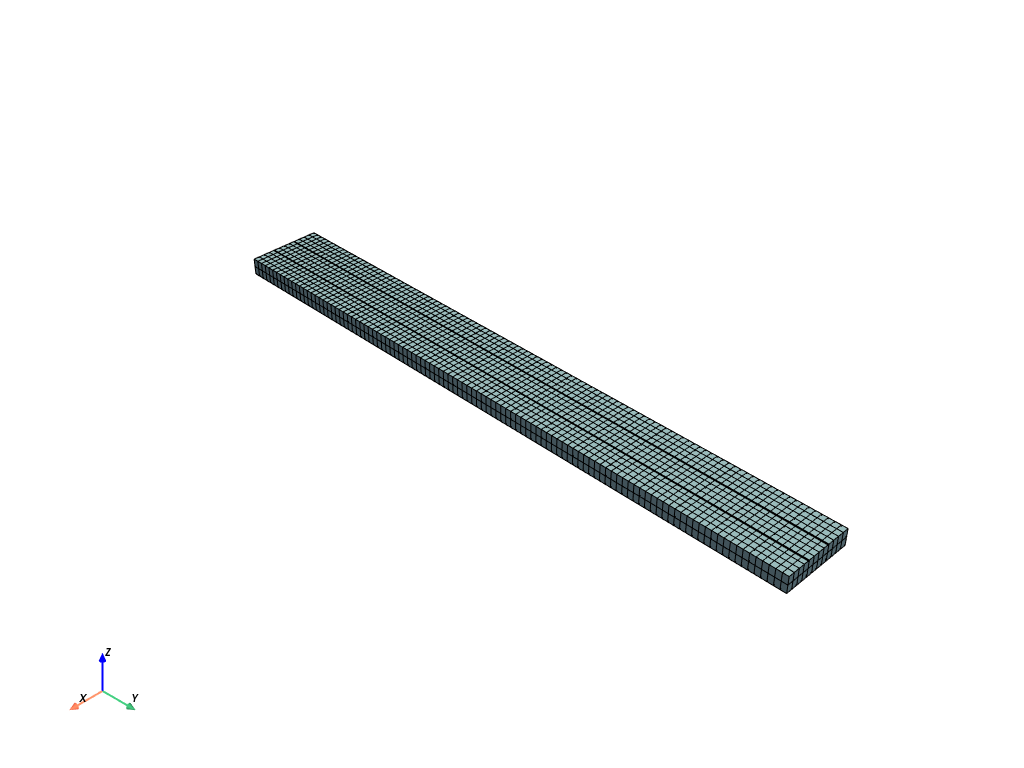

In [13]:
from resources import box_beam_utils  # import the box_beam_utils module

element_length = h/2  # example element length [mm]
example_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                   ribs_y_coordinates=ribs_y_locations,
                                                                   stiffeners_x_coordinates=stiffeners_x_locations,
                                                                   stiffeners_height=stiffeners_height,
                                                                   element_length=element_length)  # create the mesh
example_mesh.plot(show_edges=True, jupyter_backend='static')  # plot the mesh

Successively, we need to create a base bdf input, which we are going to complete for each analysis that we want to perform. For this purpose we use the function `create_base_bdf_input` from the `box_beam_utils` module. This function returns a `BDF` object, and we print a summary of its cards with the `get_bdf_stats` method.

In [14]:
nodes_xyz_array = example_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = example_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
example_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho,
                                                         shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
                                                         nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4133

bdf.elements: 0
  CQUAD4   : 4344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Finally, it's time to define our load. Analogously to our previous notebooks, we are going to consider a concentrated load applied at the tip, as shown below. We define the function `apply_tip_concentrated_load` that performs the following steps:

- add a master node at the center of the tip section;
- connect the master node to the nodes on the edge of the tip rib with a `RBE3` element, which defines the motion at a reference grid point as the weighted average of the motions at a set of other grid points;
- apply a unitary vertical force at the master point by means of a `FORCE` card, calling the function `add_uniform_force` from the `pynastran_utils` module;
- the function finally returns the id of the master node. We are going to use this node to monitor the tip displacement in our nonlinear analyses.

![Concentrated tip load applied to the box beam with a multipoint constraint.](resources/08_BoxBeamConcentratedLoad.svg "Concentrated tip load.")

In [15]:
from resources import pynastran_utils  # import the pynastran_utils module

FORCE_SET_ID = 11  # define FORCE card identification number

def apply_tip_concentrated_load(bdf_input):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = np.linalg.norm(bdf_input.nodes[2].xyz - bdf_input.nodes[1].xyz)/100  # we define a geometric tolerance equal to 1/100 of the distance between nodes
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if
                          (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &     # find nodes on the tip rib
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) |        # find nodes on the front spar
                           (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |    # find nodes on the rear spar
                           (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) |  # find nodes on the top skin
                           (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]  # find nodes on the bottom skin
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.],
                       comps=['123456'], Gijs=[tip_edge_nodes_ids])
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_uniform_force(bdf_object=bdf_input, nodes_ids=[master_node_id], set_id=FORCE_SET_ID,
                                      direction_vector=force_direction)
    # Return id of master node
    return master_node_id

Now we have all the ingredients to move on to the analysis of our new box beam model.

## Mesh convergence study <a name="mesh-convergence"></a>

***

Analogously to our old box beam models, we need perform a mesh convergence study to establish an appropriate mesh size for our analyses. For this reason, we define 10 different target element lengths, evenly spaced on a log scale between half the height of the box beam and 1/8 of the stiffners' height.

In [16]:
# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
target_element_lengths = np.geomspace(h/2, stiffeners_height/8, 10) # [m]
np.set_printoptions(precision=1, suppress=True)
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(target_element_lengths)

Prescribed length of shell elements for mesh convergence study [mm]:
[385.  255.5 169.6 112.6  74.7  49.6  32.9  21.8  14.5   9.6]


For each target element length, we generate a mesh, create the base `BDF` ojbect, apply the the concentrated load at the tip, and finally run a linear buckling analysis by calling the function `run_sol_105` from the `pynastran_utils` module, which sets up and execute Nastran's SOL 105. For each analysis we store the number of degrees of freedom of the model and the critical linear buckling load to monitor how the latter changes with the former.

subcase=0 already exists...skipping


Nastran job sol_105_4344_elements.bdf completed
Wall time: 2.0 s
Results of model with:
    - 385.0 mm prescribed element length
    - 4344 elements
    - 24522 degrees of freedom
Buckling load: 13359 N
Buckling mode:


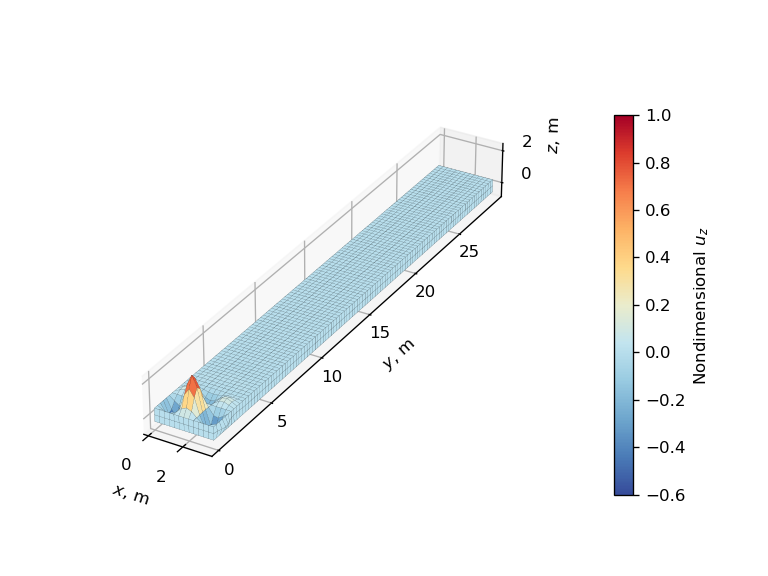

subcase=0 already exists...skipping


Nastran job sol_105_8856_elements.bdf completed
Wall time: 4.0 s
Results of model with:
    - 255.5 mm prescribed element length
    - 8856 elements
    - 50442 degrees of freedom
Buckling load: 12702 N
Buckling mode:


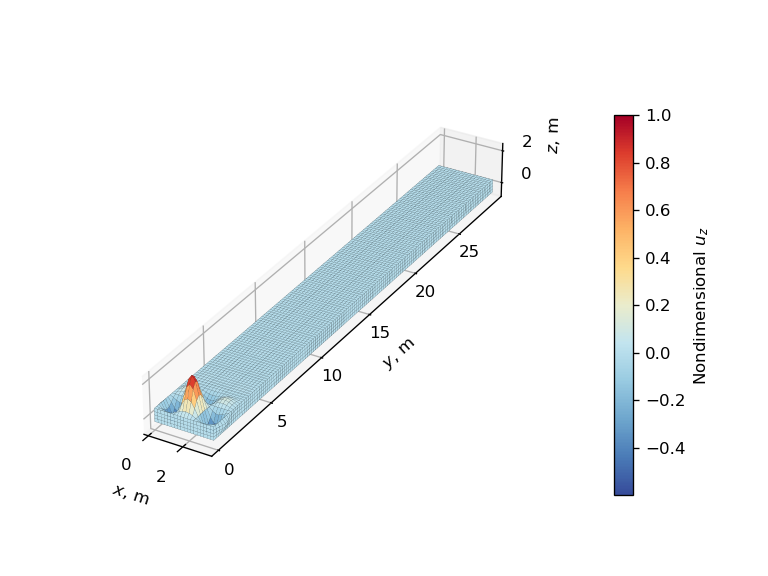

subcase=0 already exists...skipping


Nastran job sol_105_14976_elements.bdf completed
Wall time: 6.0 s
Results of model with:
    - 169.6 mm prescribed element length
    - 14976 elements
    - 85866 degrees of freedom
Buckling load: 12517 N
Buckling mode:


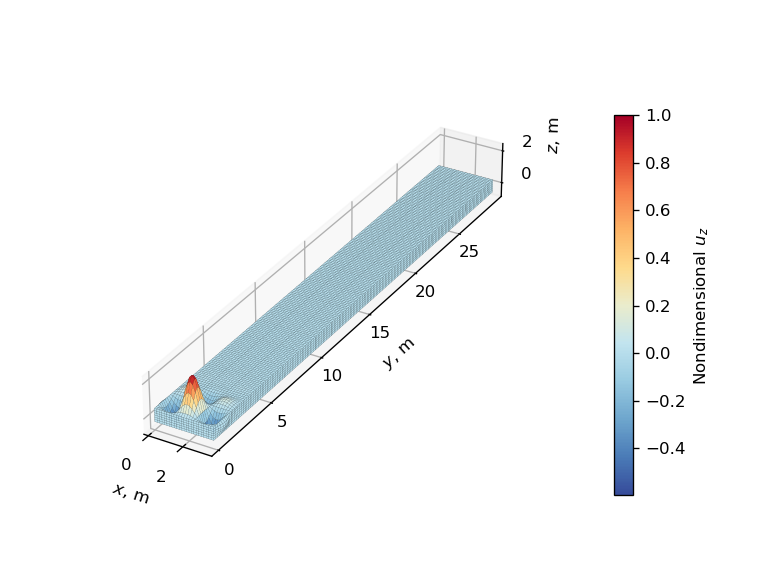

subcase=0 already exists...skipping


Nastran job sol_105_33120_elements.bdf completed
Wall time: 19.0 s
Results of model with:
    - 112.6 mm prescribed element length
    - 33120 elements
    - 192354 degrees of freedom
Buckling load: 12414 N
Buckling mode:


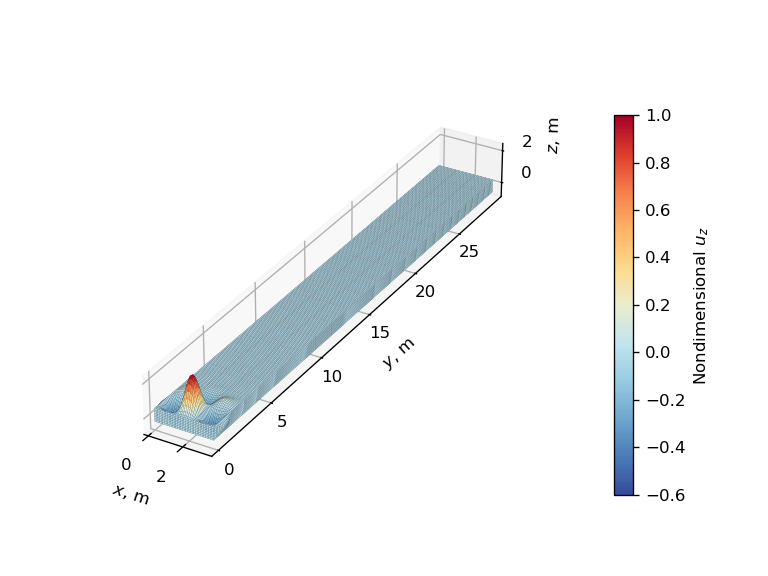

subcase=0 already exists...skipping


Nastran job sol_105_61632_elements.bdf completed
Wall time: 32.0 s
Results of model with:
    - 74.7 mm prescribed element length
    - 61632 elements
    - 359970 degrees of freedom
Buckling load: 12404 N
Buckling mode:


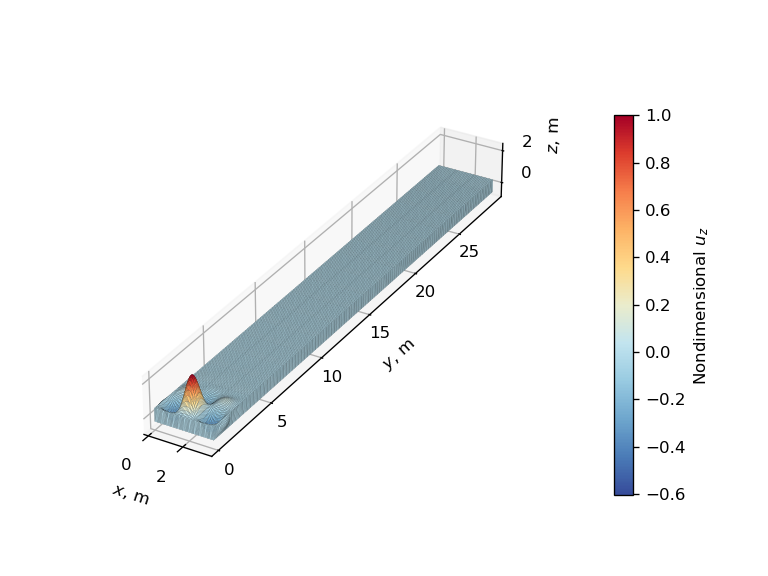

subcase=0 already exists...skipping


Nastran job sol_105_134496_elements.bdf completed
Wall time: 84.0 s
Results of model with:
    - 49.6 mm prescribed element length
    - 134496 elements
    - 790674 degrees of freedom
Buckling load: 12406 N
Buckling mode:


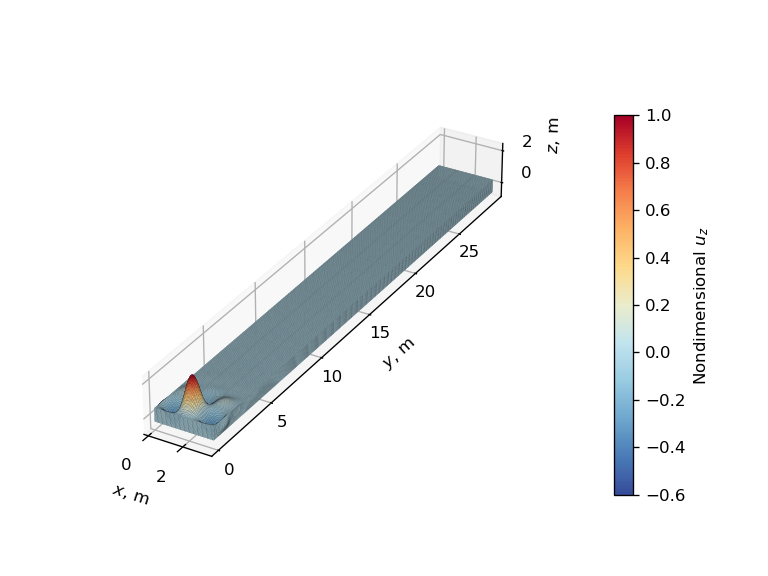

subcase=0 already exists...skipping


Nastran job sol_105_301248_elements.bdf completed
Wall time: 280.0 s
Results of model with:
    - 32.9 mm prescribed element length
    - 301248 elements
    - 1777794 degrees of freedom
Buckling load: 12401 N
Buckling mode:


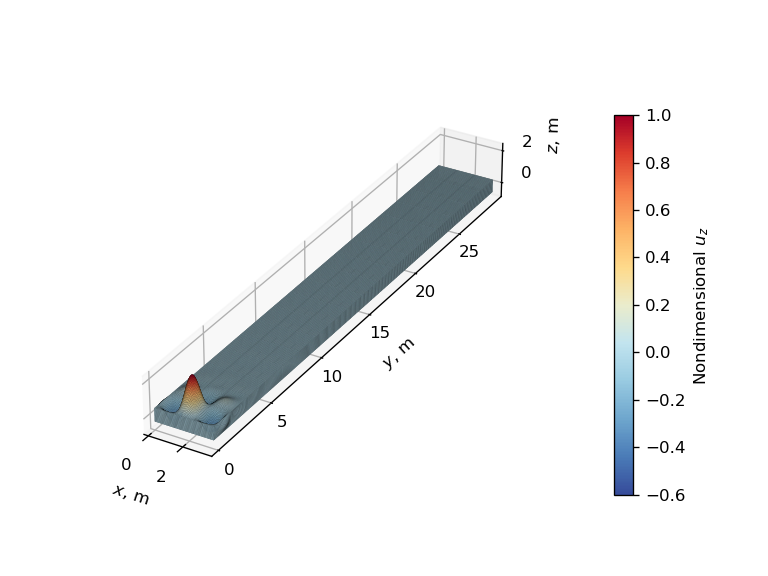

subcase=0 already exists...skipping


Nastran job sol_105_674424_elements.bdf completed
Wall time: 613.0 s
Results of model with:
    - 21.8 mm prescribed element length
    - 674424 elements
    - 3990282 degrees of freedom
Buckling load: 12408 N
Buckling mode:


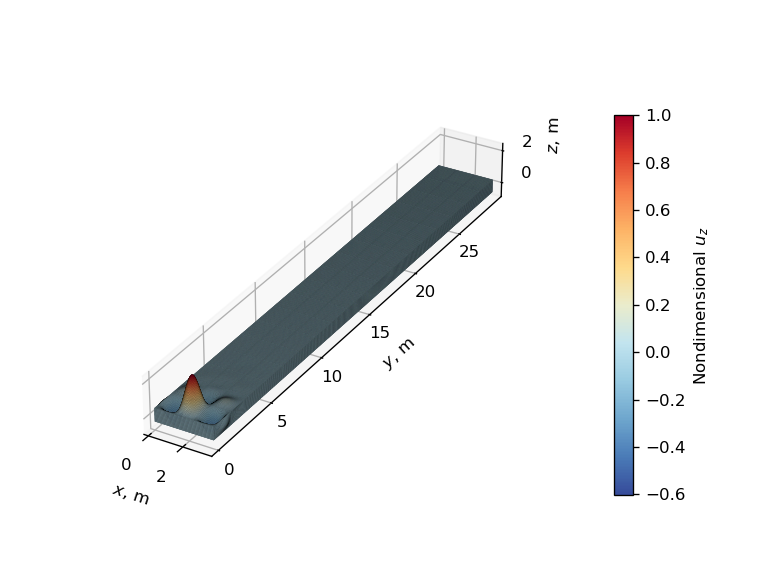

subcase=0 already exists...skipping


Nastran job sol_105_1502064_elements.bdf completed
Wall time: 2077.0 s
Results of model with:
    - 14.5 mm prescribed element length
    - 1502064 elements
    - 8902986 degrees of freedom
Buckling load: 12408 N
Buckling mode:


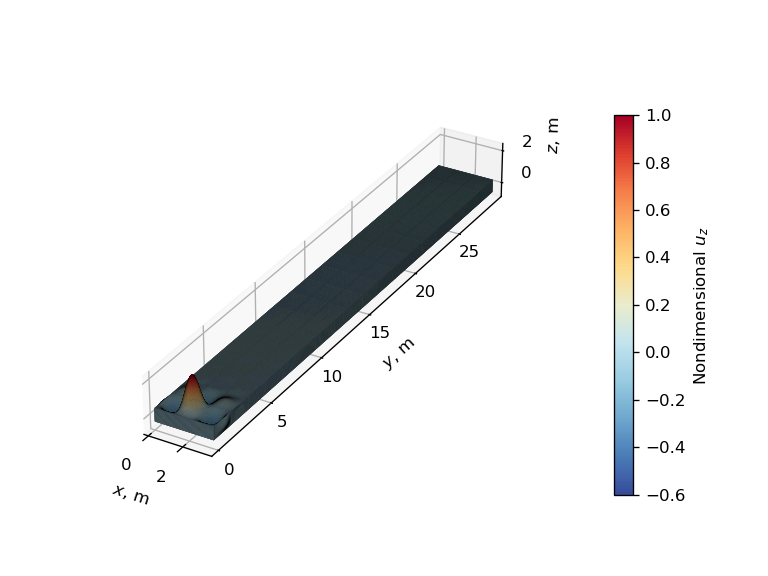

subcase=0 already exists...skipping


Nastran job sol_105_3337920_elements.bdf completed
Wall time: 6800.0 s
Results of model with:
    - 9.6 mm prescribed element length
    - 3337920 elements
    - 19803858 degrees of freedom
Buckling load: 12418 N
Buckling mode:


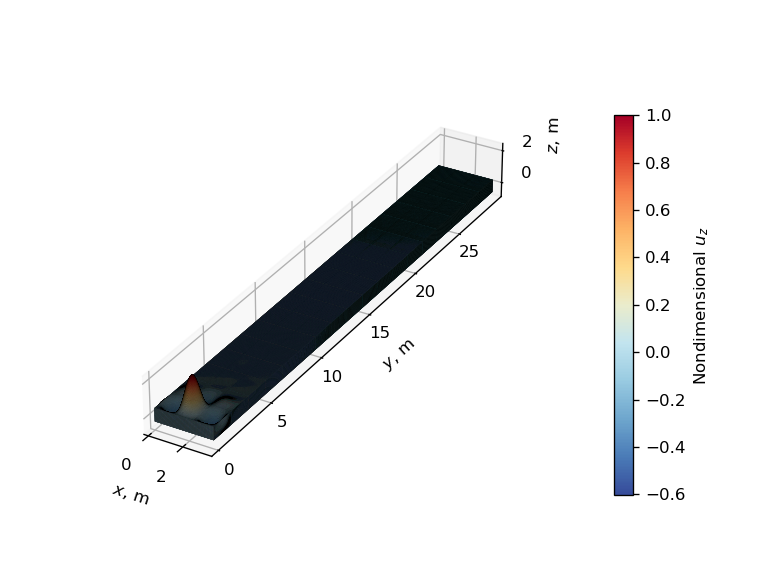

In [17]:
SECOND_SUBCASE_ID = 2  # define subcase id of eigenvalue calculation

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(target_element_lengths), dtype=int)
dofs = np.empty(np.shape(target_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(target_element_lengths))

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Iterate through the different edge lengths
amplification_factor = 2  # amplification factor for displacements of buckling mode
for count, element_length in enumerate(target_element_lengths):
    # Generate base bdf input
    box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
        width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=stiffeners_height, element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho,
                                                               shell_thickness=t, nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Apply concetrated load at the tip
    apply_tip_concentrated_load(linear_buckling_bdf)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Run SOL 105 and return OP2 object
    input_name = f"sol_105_{no_elements[count]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105(bdf_object=linear_buckling_bdf, static_load_set_id=FORCE_SET_ID,
                                              analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)
    # Find critical buckling load and print it
    print(f"""\033[1mResults of model with:
    - {element_length:.1f} mm prescribed element length
    - {no_elements[count]:d} elements
    - {dofs[count]:d} degrees of freedom\033[0m""")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    # Plot critical buckling mode
    print("Buckling mode:")
    _, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz',
                                                     length_unit='m', displacement_amplification_factor=amplification_factor,
                                                     unit_scale_factor=1e-3, colormap='sunset')
    adjust_3d_plot(ax, cbar)
    plt.show()

Let's plot the linear buckling loads against the number of degrees of freedom. We also calculate the percentage difference of each linear buckling load with respect to the one obtained with the finest mesh and visualize it on the right axis.

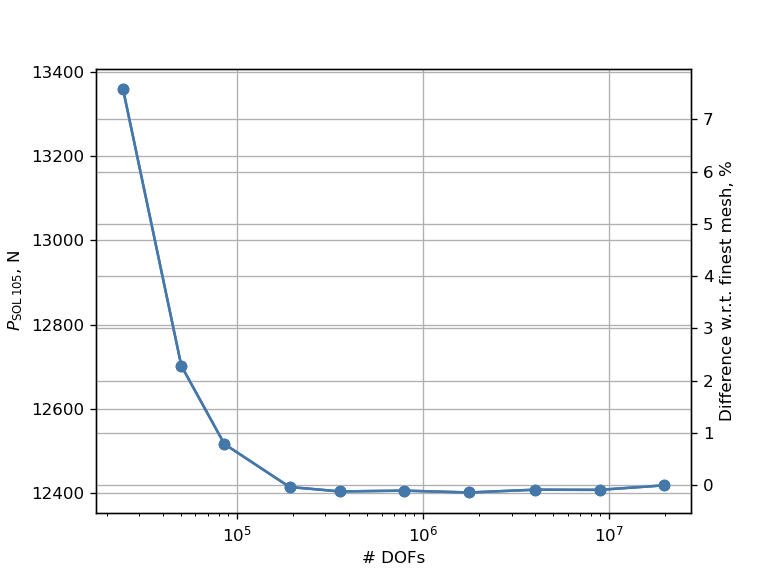

In [18]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1] - 1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel("# DOFs")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, %")
ax1.grid(True)
ax2.grid(True)
plt.show()

We define the mesh to be converged when the difference with respect to the finest mesh is below 1%.

In [19]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index corresponding to first percentage difference below 1
element_length_converged_mesh = np.round(target_element_lengths[converged_mesh_index], 1)  # round to 1 decimal for reproducibility
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
sol_105_buckling_load = np.round(linear_buckling_loads[converged_mesh_index])  # round to integer for reproducibility
print(f"""
The mesh is converged for a target shell element length of {element_length_converged_mesh:.1f} mm,
corresponidng to {no_elements_converged_mesh} elements, {dofs[converged_mesh_index]} degrees of freedom
and to a linear buckling load of {sol_105_buckling_load:.0f} N.""")


The mesh is converged for a target shell element length of 169.6 mm,
corresponidng to 14976 elements, 85866 degrees of freedom
and to a linear buckling load of 12517 N.


## Nonlinear analysis: mesh convergence verification <a name="mesh-verification"></a>

***

For our mesh convergence study we have run several linear buckling analyses to monitor the change of the critical buckling load with the number of degrees of freedom. However, a slender structure like our new box beam might have a highly nonlinear response and consequently the mesh selected from our convergence study might actually be inadequate to capture it. For this reason we want to verify the convergence of the mesh in the nonlinear regime.

We are going to do this by comparing the tip and the local displacement resulting from a nonlinear analysis with two different meshes: the mesh selected from our convergence study, which we refer to as the "original" mesh, and a refined mesh obtained by halving the target element length of the original mesh. To evaluate the local displacement of the two different models we are going to select the node where the linear buckling analysis predits the largest displacement for the critical buckling mode and we'll consider the main displacement component. Looking at the critical buckling modes of the mesh convergence study, we can say that this node corresponds to the one at the center of the first rib-stiffener bay, and the main displacement component is along the $z$-axis.

We create our first bdf input using the original mesh. Then we apply twice the linear buckling load predicted by SOL 105 to explore the nonlinear response of the structure.

In [20]:
# Create mesh with original target element length and create base bdf input
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length_converged_mesh)
box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points,
                                                    box_beam_mesh.faces.reshape(-1, 5)[:, 1:])

# Apply concentrated load at the tip and scale it to twice the linear buckling load
key = "original mesh"
tip_master_node_id = {key: apply_tip_concentrated_load(box_beam_bdf)}
LOAD_SET_ID = FORCE_SET_ID + 1  # id of load set
scale_factor = sol_105_buckling_load*2  # scale factor to apply to the load set
box_beam_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])  # add LOAD card
FIRST_SUBCASE_ID = 1  # id of first subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)  # create subcase with static load

subcase=0 already exists...skipping


 Now we need to set up SOL 106 with the arc-length method. We use the same combination of parameters of our [last notebook](17_Nonlinear_Buckling_Analysis_of_the_uCRM-9.ipynb#natural-path), inspired by the shallow cylindrical shell snap-through example from the _MSC Nastran Demontration Problems Guide - Implicit Nonlinear_:

- $\Delta\mu^1=0.01$;
- $\mathrm{MAXITER}=5$;
- load and displacement error functions with vector component method;
- $\mathrm{EPSP}=\mathrm{EPSU}=10^{-3}$;
- $\mathrm{MAXBIS}=10$;
- $\mathrm{MINALR}=0.01$;
- $\mathrm{MAXALR}=1.0001$;
- $\mathrm{DESITER}=5$;
- $\mathrm{MXINC}=1500$.

This parameters enforce fine quasi-constant arc-length increments and limit the possibilities that the solver jumps from one equilibrium path to another, as observed in [notebook 15](15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs.ipynb#visualization).

In [21]:
fine_nlparm_id = 1  # id of NLPARM card with fine arc-length method parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, ninc=100, max_iter=5, conv='PUV', eps_p=1e-3,
                                         eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5,
                                         maxinc=1500)

We run our nonlinear analysis monitoring the 20 smallest-magnitude eigenvalues of the tangent stiffness matrix, so that we can check the stability of the structure.

In [22]:
METHOD_SET_ID = LOAD_SET_ID + 1
NO_EIGENVALUES = 20
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver
input_name_dict = {key: f"sol_106_{no_elements_converged_mesh}_elements"}
sol_106_op2_dict = {key: pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict[key], upper_eig=UPPER_EIGENVALUE, run_flag=False)}


Nastran job sol_106_14976_elements.bdf completed
Wall time: 11572.0 s


We read the tip displacement from the op2 file, corresponding to the $z$-displacement of the master node of the tip section.

In [23]:
Z_COMPONENT_INDEX = 2  # index of z component of displacement
final_tip_displacement = {key: sol_106_op2_dict[key].displacements[FIRST_SUBCASE_ID].data[
    -1, tip_master_node_id[key] - 1, Z_COMPONENT_INDEX]}  # read z displacement of subcase 1, last converged iteration

To find the node associated to the local displacement, we need to find the node where the linear buckling analysis predicts the largest displacement for the critical buckling mode. Consequently, we read the op2 file corresponding to the linear buckling analysis performed during the mesh convergence study and we look for the node where the first eigenvector has the largest displacement.

In [24]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of linear buckling analysis
input_name = f"sol_105_{no_elements_converged_mesh}_elements"
sol_105_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = {key: np.argmax(np.linalg.norm(
    sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))}  # find index of max displacement magnitude
max_displacement_node_id = {key: sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[
    max_displacement_index[key], 0]}

Now we visualize the buckling mode and the location of the selected node.

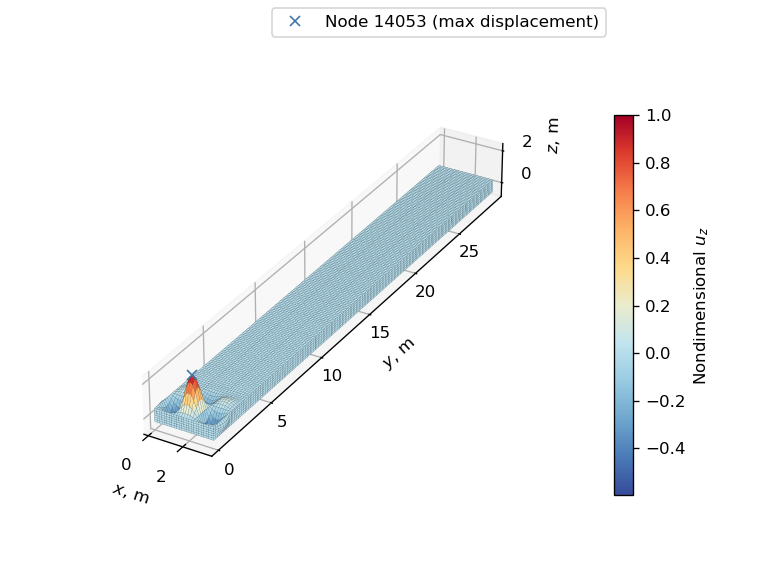

In [25]:
# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id[key]].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index[key], 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], "x",
        label=f"Node {max_displacement_node_id[key]:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Successively, we read the local displacement from the op2 file, which corresponds to the $z$-displacement of the selected node.

In [26]:
final_local_displacement = {key: sol_106_op2_dict[key].displacements[FIRST_SUBCASE_ID].data[
    -1, max_displacement_index[key], Z_COMPONENT_INDEX]}  # read z displacement of subcase 1, last converged iteration

Now we create the model with a refined mesh, where we prescribe a target element length equal to half that of the original mesh.

In [27]:
# Create mesh with half of the original target element length
box_beam_refined_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length_converged_mesh/2)

# Create BDF object and apply concentrated load at the tip
box_beam_refined_mesh_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_refined_mesh.points,
                                                                 box_beam_refined_mesh.faces.reshape(-1, 5)[:, 1:])
key = "refined mesh"
tip_master_node_id[key] = apply_tip_concentrated_load(box_beam_refined_mesh_bdf)

subcase=0 already exists...skipping


We first run a linear buckling analysis calling the function `run_sol_105`, in order to find the node where the critical buckling mode has the largest displacement. Then we plot the critical buckling mode highlighting the mentioned node.

Nastran job sol_105_48300_elements.bdf completed
Wall time: 26.0 s


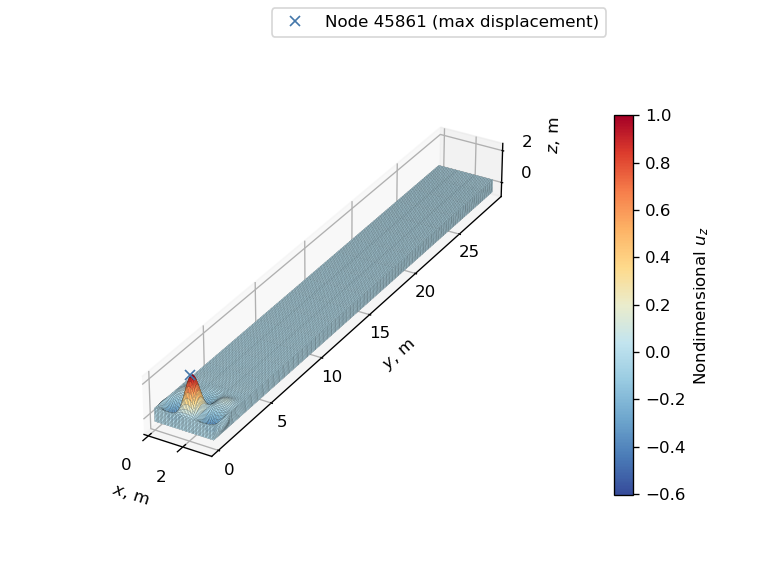

In [28]:
# Run SOL 105 and return OP2 object
no_elements_refined_mesh = len(box_beam_refined_mesh_bdf.elements)
input_name = f"sol_105_{no_elements_refined_mesh}_elements"
sol_105_op2_refined_mesh = pynastran_utils.run_sol_105(
    bdf_object=box_beam_refined_mesh_bdf.__deepcopy__({}), static_load_set_id=FORCE_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=False)

# Find node where max displacement occurs
max_displacement_index[key] = np.argmax(np.linalg.norm(sol_105_op2_refined_mesh.eigenvectors[
    SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id[key] = sol_105_op2_refined_mesh.eigenvectors[
    SECOND_SUBCASE_ID].node_gridtype[max_displacement_index[key], 0]

# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2_refined_mesh,
                                                 subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
refined_mesh_max_displacement_node_xyz = sol_105_op2_refined_mesh.nodes[max_displacement_index[key]].xyz*1e-3 +\
    sol_105_op2_refined_mesh.eigenvectors[SECOND_SUBCASE_ID].data[0, max_displacement_index[key], 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(refined_mesh_max_displacement_node_xyz[0],
        refined_mesh_max_displacement_node_xyz[1],
        refined_mesh_max_displacement_node_xyz[2],
        "x", label=f"Node {max_displacement_index[key]:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

We define the subcase for the nonlinear analysis applying the same load as for the original model, set up SOL 106 with the arc-length method using the same parameters of the last analysis, and we run the analysis.

In [29]:
# Create static load subcase with twice the buckling load predicted by SOL 105
box_beam_refined_mesh_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_refined_mesh_bdf, subcase_id=FIRST_SUBCASE_ID,
                                           load_set_id=LOAD_SET_ID)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_refined_mesh_bdf, ninc=100, max_iter=5, conv='PUV', eps_p=1e-3,
                                         eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.0001, desiter=5, maxinc=1500)

# Run analysis
input_name_dict[key] = f"sol_106_{no_elements_refined_mesh}_elements"
sol_106_op2_dict[key] = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf_object=box_beam_refined_mesh_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict[key], upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job sol_106_48300_elements.bdf completed
Wall time: 49672.0 s


Also in this case we read the local and tip displacement from the op2 file.

In [30]:
final_local_displacement[key] = sol_106_op2_dict[key].displacements[FIRST_SUBCASE_ID].data[
    -1, max_displacement_index[key], Z_COMPONENT_INDEX]  # read z displacement of local node in subcase 1, last converged iteration
final_tip_displacement[key] = sol_106_op2_dict[key].displacements[FIRST_SUBCASE_ID].data[
    -1, tip_master_node_id[key] - 1, Z_COMPONENT_INDEX]  # read z displacement of tip node in subcase 1, last converged iteration

Finally, we can calculate the percentage difference of the displacements obtained with the original mesh w.r.t. to those obtained with the refined mesh.

In [31]:
print(f"""Percentage difference of original mesh w.r.t. refined mesh:
- tip displacement: {(final_tip_displacement["original mesh"]/final_tip_displacement["refined mesh"] - 1)*100:.1f} %
- local displacement: {(final_local_displacement["original mesh"]/final_local_displacement["refined mesh"] - 1)*100:.1f} %""")

Percentage difference of original mesh w.r.t. refined mesh:
- tip displacement: -1.0 %
- local displacement: 3.5 %


The difference for both displacements is smaller than 5%, suggesting that the mesh selected with the convergence study appears to be adequate for the kind of nonlinear analyses that we are going to carry out in the remainder of the notebook. However, the final value of local and tip displacements gives only a partial picture of the accuracy of the mesh. In fact, in our nonlinear analyses the equilibrium path followed by the structure might be more important than the final deformation. For this reason, we are now going to compare the equilibrium paths followed by the arc-length solver during the two analyses that we've just performed.

To do this, we plot the equilibrium paths in a 3D equilibrium diagram, where we use the $x$-axis to represent the local displacement, the $y$-axis to represent the tip displacement and the $z$-axis to represent the applied load. We read the history of these quantities from the op2 files using the function `read_load_displacement_history` from the `pynastran_utils` module. The local displacement is nondimensionalized with the width of the box beam, the tip displacement with the length of the box beam and the applied load with the buckling load predicted by SOL 105.

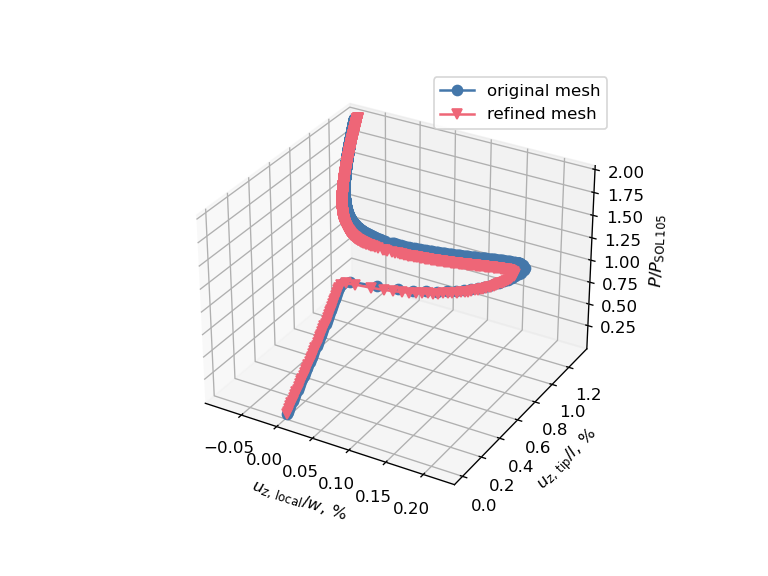

In [32]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Create dictionaries to store nondimensional displacements and applied loads
nondimensional_local_displacements = {}
nondimensional_tip_displacements = {}
nondimensional_applied_loads = {}

# Create list with default color cycle and list of marker characters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
markers = list(Line2D.markers.keys())[2:]  # list of marker characters

# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(sol_106_op2_dict):
    # Read loads and displacements history from op2 file
    _, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2_dict[key], displacement_node_id=max_displacement_node_id[key])
    _, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=sol_106_op2_dict[key], displacement_node_id=tip_master_node_id[key])
    # Nondimensionalize loads and displacements
    nondimensional_applied_loads[key] = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/sol_105_buckling_load
    nondimensional_local_displacements[key] = local_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w
    nondimensional_tip_displacements[key] = tip_displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l
    # Plot loads and displacements
    ax_3d.plot3D(nondimensional_local_displacements[key]*100, nondimensional_tip_displacements[key]*100,
                 nondimensional_applied_loads[key], markers[count] + '-', color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel("$u_{z,\,\mathrm{local}}/w$, %")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

The two equilibrium paths are very close to each other, suggesting that the original mesh is adequate for our nonlinear analyses. At the same time, we observe a surprising structural response. After the initial linear part of the response, the local displacement increases significantly suggesting the presence of a broken supercritical pitchfork. However, at a certain point, the local displacement reaches a maximum and then starts decreasing. Soon after the applied load does the same.

We can better observe this response in the 2D equilibrium diagram showing the applied load and the local displacement.

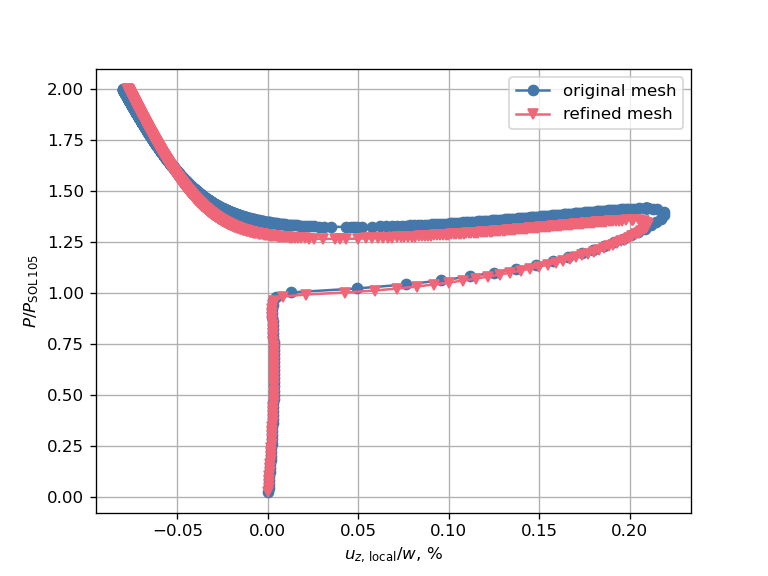

In [33]:
# Create plot of 2D equilibrium diagram
_, ax = plt.subplots()
for count, key in enumerate(nondimensional_local_displacements):
    # Plot loads and displacements
    ax.plot(nondimensional_local_displacements[key]*100, nondimensional_applied_loads[key], markers[count] + '-', color=colors[count], label=key)

# Set plot appearance
ax.set_xlabel("$u_{z,\,\mathrm{local}}/w$, %")
ax.set_ylabel("$P/P_\mathrm{SOL\/105}$")
ax.grid(visible=True)
ax.legend()
plt.show()

From the above plot, it is evident that also the applied load achieves a local maximum and then decreases. Over this segment of the equilibrium path, the local displacement switches from positive to negative. At a certain point the applied load achieves a local minimum and then starts increasing again, while the local displacement keeps increasing in magnitude once it has become negative.

This type of response suggests the presence of two load limit points, one where the applied load reaches the local maximum and the other where it reaches the local minimum. We expect the structure to be unstable and for this reason we expect to see a negative eigenvalue of the tangent stiffness matrix between these points. Let's check this by plotting the 20 smallest-magnitude eigenvalues of the tangent stiffness matrix against the applied load.

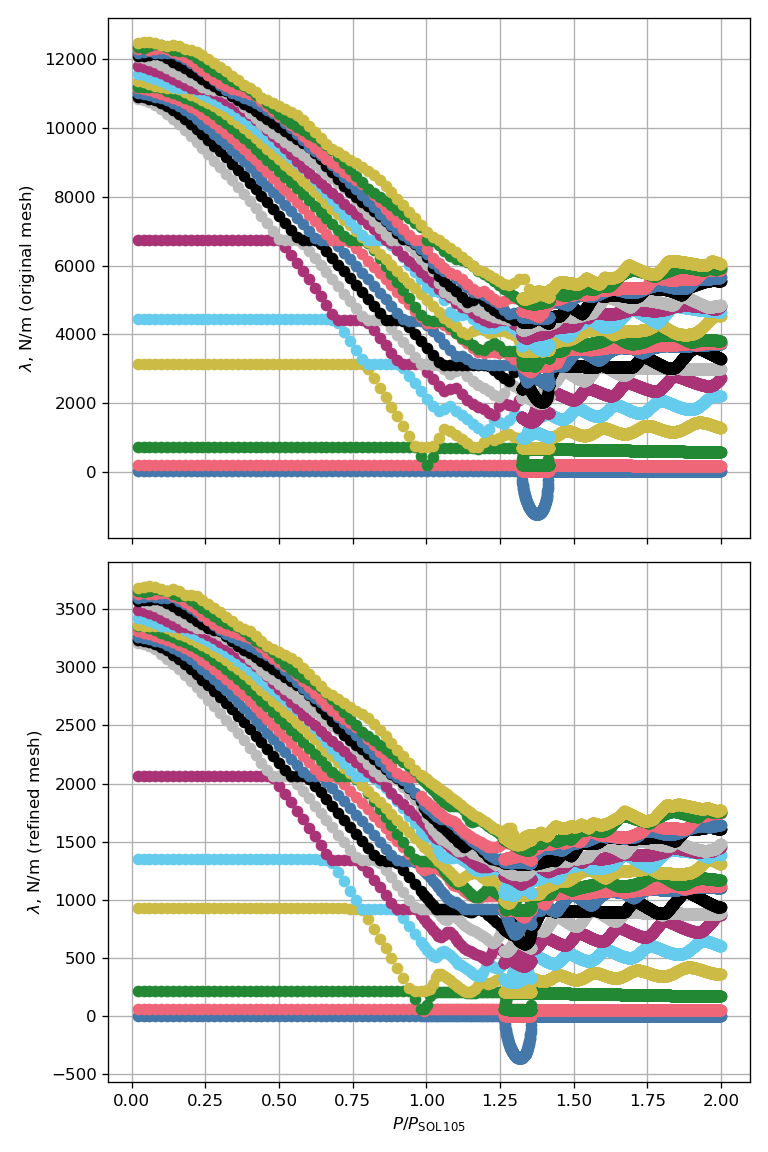

In [34]:
eigenvalues_dict = {}  # dictionary to store eigenvalues

# Create the figure with two subplots
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8*2))
for count, key in enumerate(input_name_dict):
    # Read eigenvalues from f06 file
    f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict[key] + '.f06')  # path to .f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath=f06_filepath)
    # Plot eigenvalues vs nondimensional applied loads
    axes[count].plot(nondimensional_applied_loads[key], eigenvalues_dict[key].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    axes[count].set_ylabel(f"$\lambda$, N/m ({key})")
    axes[count].grid(True)

# Finalize plot appearance
axes[count].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.tight_layout()  # adjust subplots' layout
plt.show()

The two eigenvalue diagrams show indeed the presence of a negative eigenvalue, however within a slightly different load range for the two meshes. This confirms the presence of the two load limit points. In a real-world scenario this means that when the box beam is loaded beyond its first load limit point it will exhibit a snap-through behavior, with the structure suddenly changing its deformation to that corresponding to the first stable equilibrium point available at the applied load.

Furthermore, the overall response looks very similar, only the magnitude of the eigenvalues of the model with the refined mesh is significatively smaller. The eigenvalues of the tangent stiffness matrix represent the stiffness associated to the principal stiffness directions corresponding to its eigenvectors, and coarse meshes are known to have a stiffening effect on FE models, so the observed smaller magnitude should not be a surprise.

Let's find the nondimensional load corresponding to the first limit point for both models, and calculate the percentage difference of the original mesh with respect to the refined mesh.

In [35]:
# Find applied load at limit point
first_negative_eigenvalue_index = {}  # dictionary to store index of first negative eigenvalue
limit_point_nondimensional_applied_load = {}  # dictionary to store nondimensional applied load at limit point
for key in eigenvalues_dict:
    first_negative_eigenvalue_index[key] = np.where(eigenvalues_dict[key][0, :] < 0)[0][0]  # find index of first negative eigenvalue
    limit_point_nondimensional_applied_load[key] = np.mean(
        nondimensional_applied_loads[key][first_negative_eigenvalue_index[key] - 1:first_negative_eigenvalue_index[key] + 1])  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load

# Print applied loads and percentage difference
print(f"""
Nondimensional applied load at first limit point:
- original mesh: {limit_point_nondimensional_applied_load["original mesh"]:.2f}
- refined mesh: {limit_point_nondimensional_applied_load["refined mesh"]:.2f}
Percentage difference of original mesh w.r.t. refined one: {
    (limit_point_nondimensional_applied_load["original mesh"]/limit_point_nondimensional_applied_load["refined mesh"] - 1)*100:.1f} %""")


Nondimensional applied load at first limit point:
- original mesh: 1.42
- refined mesh: 1.36
Percentage difference of original mesh w.r.t. refined one: 4.3 %


Also for the first limit point the difference is smaller than 5%, suggesting that the original mesh is adequate for our nonlinear analyses.

Finally, it's interesting to visualize the deformation of the box beam along the equilibrium path, especially to observe what part of the box beam is involved in the snap-through behavior associated with the limit point bifucations. We select three points along the load-displacement curve: one at $P/P_\mathrm{SOL 105}=0.5$, to visualize the deformation in the linear part of the response, and the other two just before and after the snap. We only plot the deformation of the original model and we amplify the displacements by a factor 50 for visualization purposes.

Deformation at P/P_SOL 105 = 0.5:


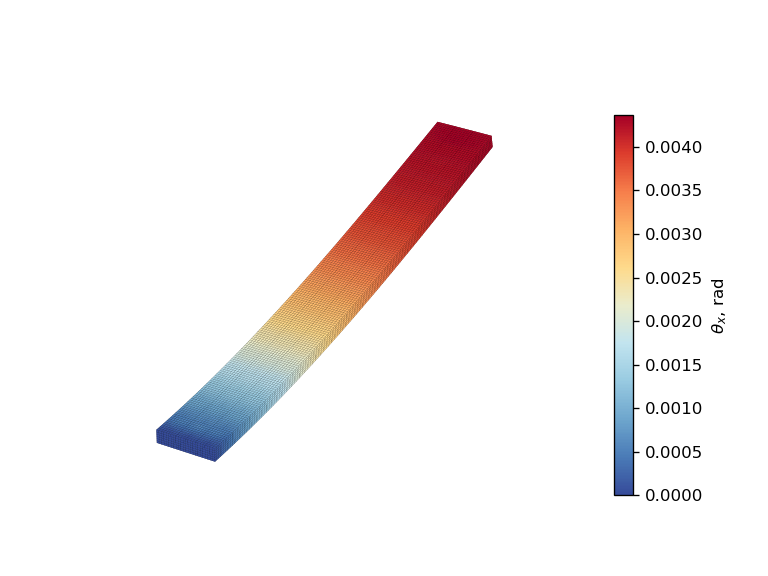

Deformation just before snap


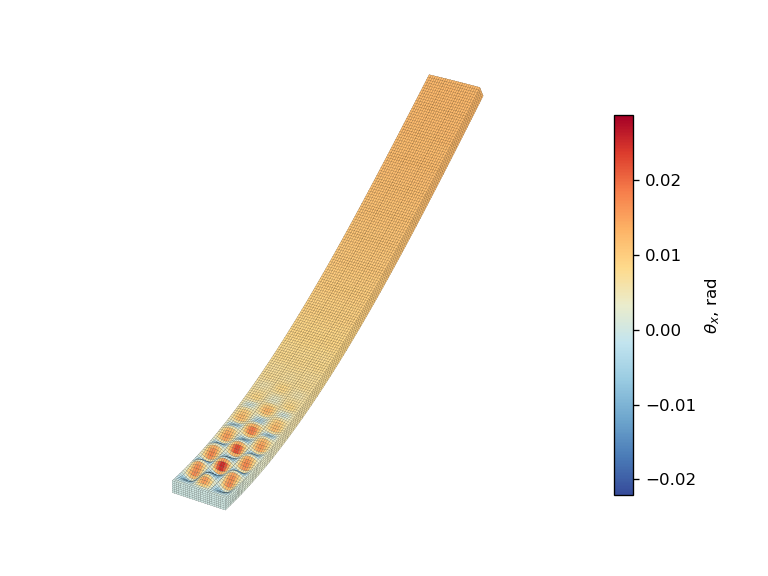

Deformation just after snap


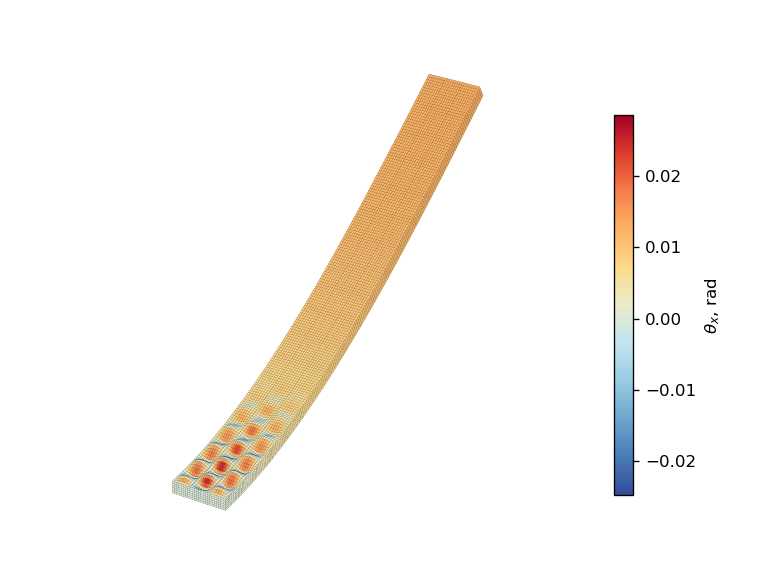

In [36]:
# Plot deformation at P/P_SOL 105 = 0.5
nondimensional_applied_linear_regime = .5
ORIGINAL_MESH_KEY = "original mesh"
increment_number = np.argmin(np.abs(nondimensional_applied_loads[ORIGINAL_MESH_KEY] - nondimensional_applied_linear_regime)) + 1  # find number of closest converged increment to applied load
amplification_factor = 50  # amplification factor for displacements
print("Deformation at P/P_SOL 105 = 0.5:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[ORIGINAL_MESH_KEY], subcase_id=FIRST_SUBCASE_ID, load_step=increment_number,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation just before snap
print("Deformation just before snap")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[ORIGINAL_MESH_KEY], subcase_id=FIRST_SUBCASE_ID,
                                                      load_step=first_negative_eigenvalue_index[ORIGINAL_MESH_KEY],
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_applied_loads[ORIGINAL_MESH_KEY][first_negative_eigenvalue_index[ORIGINAL_MESH_KEY] + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(limit_point_nondimensional_applied_load[ORIGINAL_MESH_KEY] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index[ORIGINAL_MESH_KEY] + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation just after snap")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[ORIGINAL_MESH_KEY], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

The deformation at $P/P_\text{SOL 105}=0.5$ is analogous to the one of a beam under linear deformation. The deformation just before the first limit point is characterized by one half-wave for the rib-stiffener bays between the first two ribs, and by two half-waves for the rib-stiffener bays between the successive ribs. After the snap, the deformation of the rib-stiffener bays between first two ribs changes into two half-waves and the rib-stiffener bays betwen successive ribs maintain the same number of half-waves.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the results of the analysis, and possibly find some complementary paths like we did in our last notebooks. In order to do this, we are going to apply twice the linear buckling load predicted by SOL 105, vary several parameters of the `NLPARM` and the `NLPCI` cards and look at how the load-displacement diagram changes.

We use the same `BDF` object of the mesh convergence verification study, and we define new `NLPARM` and `NLPCI` cards with default parameters, which we assign to the first subcase. These new cards with default parameters correspond to coarse arc-length increments. The only non-default parameter that we set is the maximum number of iterations, which we keep equal to 5 as in the analyses of the mesh convergence verification study.

In [37]:
coarse_nlparm_id = 2
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=coarse_nlparm_id, subcase_id=FIRST_SUBCASE_ID, max_iter=5)

To assess the influence of the nonlinear analysis parameters on the results, we want to observe how the equilibrium path changes with respect to the reference natural path obtained earlier. Analogously to our [last notebook](17_Nonlinear_Buckling_Analysis_of_the_uCRM-9.ipynb), we are going to monitor these changes in a 3D equilibrium diagram, where we combine local displacement, tip displacement and applied load.

For this reason, we define two functions: `plot_reference_equilibrium_path` and `plot_analysis_equilibrium_path`. The first one will create a new figure with 3D axes and plot the load-displacement curve obtained earlier from the analysis of the original mesh. The second function will run a new Nastran analysis with the current set of nonlinear analysis parameters, read the load and displacement history from the op2 file and plot the resulting load-displacement curve on the same figure of the reference one.

In [38]:
def plot_reference_equilibrium_path():
    # Create 3D plot of equilibrium diagram
    plt.figure()
    ax_3d = plt.axes(projection='3d')
    # Plot loads and displacements
    ax_3d.plot3D(nondimensional_local_displacements[ORIGINAL_MESH_KEY]*100,
                 nondimensional_tip_displacements[ORIGINAL_MESH_KEY]*100,
                 nondimensional_applied_loads[ORIGINAL_MESH_KEY],
                 'o-', label="reference natural path")
    ax_3d.set_xlabel("$u_{z,\,\mathrm{local}}/w$, %")
    ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, %")
    ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    ax_3d.grid(visible=True)
    return ax_3d

def plot_analysis_equilibrium_path(bdf_input, filename, axes, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf_object=bdf_input,
                                 filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, loads, tip_disp = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=tip_master_node_id[ORIGINAL_MESH_KEY])
    _, _, local_disp = pynastran_utils.read_load_displacement_history_from_op2(
        op2_object=op2, displacement_node_id=max_displacement_node_id[ORIGINAL_MESH_KEY])
    # Plot load-displacement curve on input axes
    axes.plot(local_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/w*100,
              tip_disp[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/l*100,
              loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/sol_105_buckling_load,
              marker=marker_style, linestyle='-', label=line_label)

### Error function <a name="error-function"></a>

We start our sensitivity study by looking at the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and energy with vector component checking;
- load and displacement;
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking. 

In [39]:
error_functions = ['PW', 'PWV', 'PU', 'PUV', 'PWU', 'PWUV']

Let's plot the natural equilibrium path, run the analyses with the different error functions and plot the results.

Nastran job sol_106_error_function_PW.bdf completed
Wall time: 325.0 s
Nastran job sol_106_error_function_PWV.bdf completed
Wall time: 330.0 s
Nastran job sol_106_error_function_PU.bdf completed
Wall time: 199.0 s
Nastran job sol_106_error_function_PUV.bdf completed
Wall time: 202.0 s
Nastran job sol_106_error_function_PWU.bdf completed
Wall time: 199.0 s
Nastran job sol_106_error_function_PWUV.bdf completed
Wall time: 203.0 s


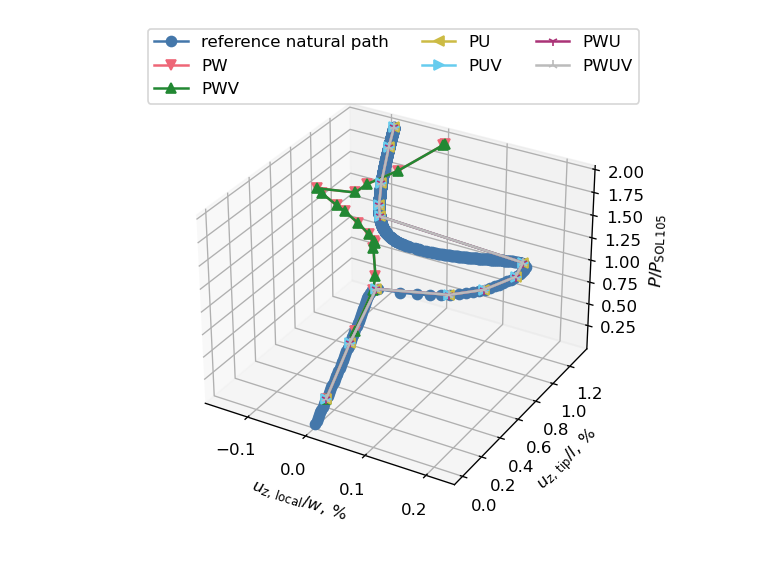

In [40]:
# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[coarse_nlparm_id].conv = fun
    input_filename = "sol_106_error_function_" + fun
    plot_analysis_equilibrium_path(box_beam_bdf, input_filename, ax, markers[count + 1], f"{fun}", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=3)
plt.show()

In the plot above we can observe two groups of equilibrium points: the first one follows the reference natural equilibrium path, while the second one appears to describe a complementary path. The only difference between the two groups is the use of the displacement error function. 

Looking at the analyses not employing the displacement error function, it is clear that a certain point there appears to be a jump from the natural path to a complementary path. We are going to investigate this complementary path by unloading the structure from the last equilibrium point using fine arc-length increments.

We select the load and energy error functions for the first subcase, define a second subcase with zero applied load, assign the `NLPARM` and `NLPCI` cards with fine arc-length increments and run the analysis.

In [41]:
# Modify nonlinear analysis parameters
box_beam_bdf.nlparms[coarse_nlparm_id].conv = 'PW'  # set error function to PU
box_beam_bdf.nlpcis[fine_nlparm_id].mxinc = 200  # reduce maximum number of increments to 200 to avoid the analysis to run for too long

# Define second subcase to unload the structure
zero_load_set_id = LOAD_SET_ID + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[FORCE_SET_ID])  # add LOAD card with zero applied load
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=SECOND_SUBCASE_ID, load_set_id=zero_load_set_id)  # create subcase with zero applied load
box_beam_bdf.case_control_deck.subcases[SECOND_SUBCASE_ID].add_integer_type('NLPARM', fine_nlparm_id)  # use NLPARM and NLPCI with fine arc-length step in second subcase

# Run analysis
input_name = "sol_106_error_function_PW_equilibrium_path_verification"
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, upper_eig=UPPER_EIGENVALUE, run_flag=False)

Nastran job sol_106_error_function_PW_equilibrium_path_verification.bdf completed
Wall time: 3227.0 s


Now we want to visualize the results both in terms of the 3D load-displacement diagram and in terms of the eigenvalues of the tangent stiffness matrix, to check the stability of the equilibrium points found in each subcase. We define two new functions for this purpose: `plot_subcases_equilibrium_path` and `plot_subcases_eigenvalues`. The first function plots the load-displacement curve of the reference natural equilibrium path and the load-displacement curves obtained from two subcases of the new analysis. The second function plots the eigenvalues of the tangent stiffness matrix against the applied load for the two subcases. Furthermore, `plot_subcases_eigenvalues` also plots the same eigenvalues against the cumulative sum of the absolute value of the load increments, to better visualize the evolution of the eigenvalues during the analysis.

Let's define these functions and plot the results of our analysis.

C:\Users\qa21944\AppData\Local\Temp\ipykernel_18332\1206463353.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


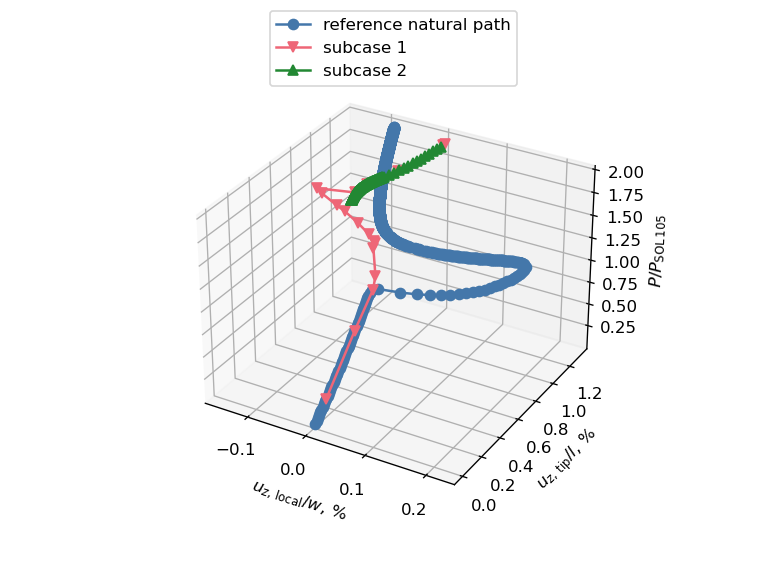

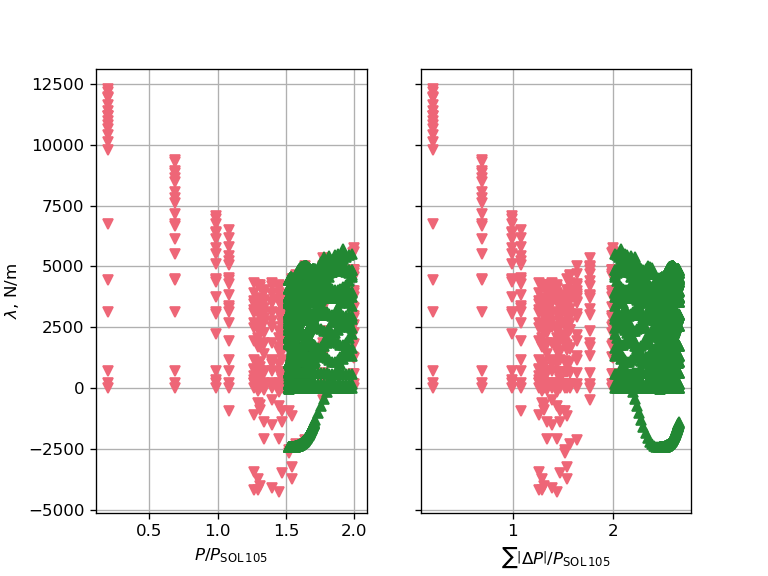

In [42]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_subcases_equilibrium_path(loads, local_disp, tip_disp):
    # Plot natural equilibrium path
    ax3d = plot_reference_equilibrium_path()
    # Plot 3D equilibrium paths of last analysis
    for subcase_id in loads:
        ax3d.plot(local_disp[subcase_id][:, Z_COMPONENT_INDEX]/w*100,
              tip_disp[subcase_id][:, Z_COMPONENT_INDEX]/l*100,
              loads[subcase_id][:, Z_COMPONENT_INDEX]/sol_105_buckling_load,
              marker=MARKERS[subcase_id], linestyle='-', label=f"subcase {subcase_id:d}")
    # Set plot appearance
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center')
    plt.show()

def plot_subcases_eigenvalues(filename, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, filename + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with two subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    # Initialize variables
    eigvals_count = 0
    eigvals_by_subcase = {}
    starting_cumsum = 0.
    # Iterate through subcases
    for subcase in loads:
        # Find eigenvalues of current subcase
        no_load_steps = len(loads[subcase])  # number of load steps in subcase
        eigvals_by_subcase[subcase] = eigvals[:, eigvals_count:eigvals_count + no_load_steps]  # store eigenvalues of current subcase
        eigvals_count += no_load_steps  # update index of eigenvalues
        # Plot eigenvalues vs applied load in first subplot
        no_valid_increments = eigvals_by_subcase[subcase].shape[1]  # when Nastran stops the analysis because the maximum number of increments is reached, it doesn't calculate the eigenvalues for the last increment
        eigvals_axs[0].plot(loads[subcase][:no_valid_increments, Z_COMPONENT_INDEX]/sol_105_buckling_load,
                            eigvals_by_subcase[subcase].T*1e3,
                            MARKERS[subcase], color=COLORS[subcase])
        # Plot eigenvalues vs cumulative load increments in second subplot
        cumsum_loads = starting_cumsum + np.cumsum(
            np.abs(np.diff(np.insert(loads[subcase][:no_valid_increments, Z_COMPONENT_INDEX], 0, starting_cumsum))))
        eigvals_axs[1].plot(cumsum_loads/sol_105_buckling_load,
                            eigvals_by_subcase[subcase].T*1e3,
                            MARKERS[subcase], color=COLORS[subcase])
        # Update starting cumulative sum
        starting_cumsum = cumsum_loads[-1]
        
    # Set plot appearance
    eigvals_axs[0].set_xlabel("$P/P_\mathrm{SOL\/105}$")
    eigvals_axs[0].set_ylabel("$\lambda$, N/m")
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel(r"$\sum \left|\Delta P\right|/P_\mathrm{SOL\/105}$")
    eigvals_axs[1].grid(visible=True)
    plt.show()

# Read load and displacement history from op2 file
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=tip_master_node_id[ORIGINAL_MESH_KEY])
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id[ORIGINAL_MESH_KEY])

# Plot equilibrium paths and eigenvalues
plot_subcases_equilibrium_path(applied_loads, local_displacements, tip_displacements)
plot_subcases_eigenvalues(input_name, applied_loads)

The load-displacement diagram shows that in the second subcsase the structure is unloaded down to an applied load of approximately $P/P_\text{SOL 105}=1.5$ and then it's loaded again over the same load-displacement trajectory. The eigenvalue diagrams suggests that the first subcase ends on an unstable equilibrium point, given the presence of several negative eignvalues at previous iterations. The magnitude of these eigenvalues is probably too large to fall within the smallest 20. During the second subcase we observe one eigenvalue becoming negative at about $P/P_\text{SOL 105}=1.8$, and another one close to $P/P_\text{SOL 105}=1.5$, where the arc-length solver starts loading again the structure. The latter suggests the presence of a limit point. By inspecting the shape of the load-displacement curve, we can infer that we are in presence of a displacement limit point.

It is not uncommon for the arc-length solver to bounce back at displacement limit points, due to the different order of matnitudes between the load and the displacement increments. In these cases, it is in fact possible that the load increment changes sign incorrectly, leading to the observed "bounce-back" in the load-displacement curve. To avoid this issue we should use a different formulation of the arc-length method, which is not available in Nastran, or try different nonlinear analysis parameters in the hope that the solver will end in the basin of attraction of the correct equilibrium point. However, this is beyond the scope of what we are interested in here.

To further show the difference between the last equilibrium point of the first subcase and the one of the reference natural path, we plot the deformation of the box beam at these points.

Deformation on reference natural path:


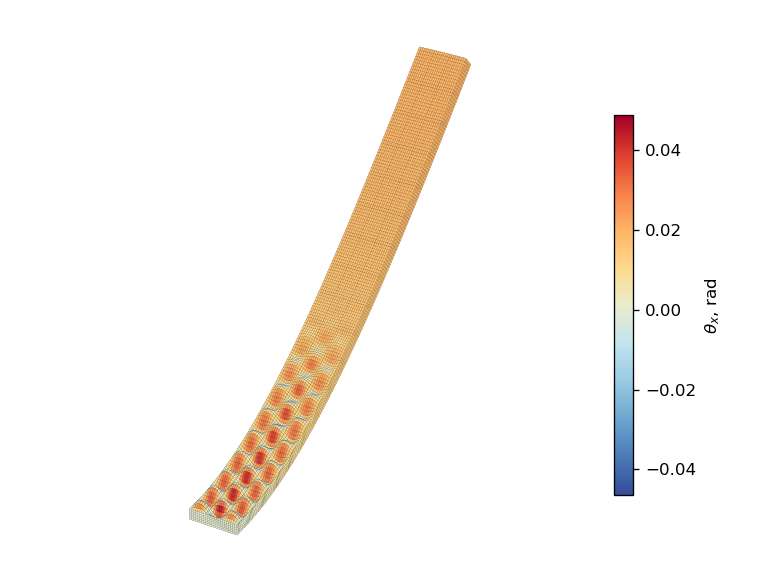

Deformation on complementary path:


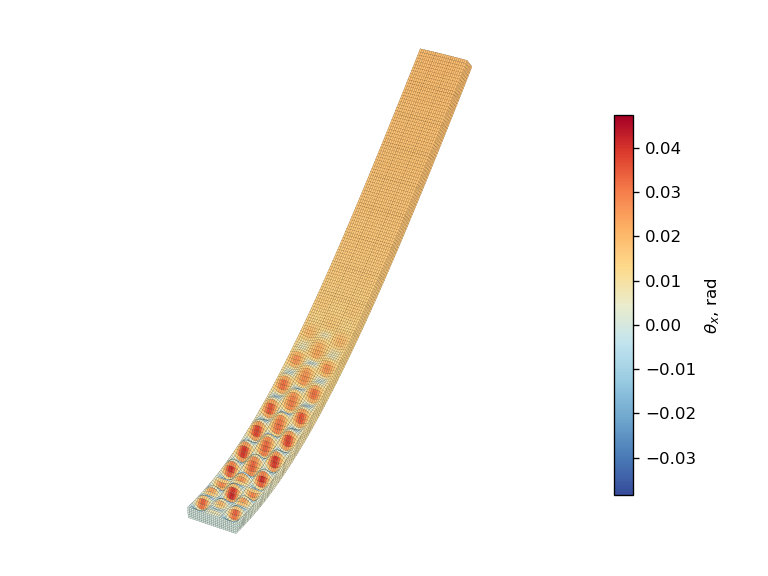

In [43]:
# Plot deformation on reference natural path
print("Deformation on reference natural path:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[ORIGINAL_MESH_KEY], subcase_id=FIRST_SUBCASE_ID,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation at the end of first subcase of the new analysis
print("Deformation on complementary path:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=FIRST_SUBCASE_ID,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

Comparing the deformation on the complementary path to that on the natural path we observe that the first central rib-stiffener bay presents three half-waves instead of two. In addition to that, there is a phase shift of the half-waves over the first side rib-stiffener bays and of the half-waves from the third rib bay onwards. This confirms the different equilibrium state of the structure on the complementary path with respect to the natural path. Furthermore, we can expect the existence of several other equilibrium states for the same applied load, each characterized by a different number of half-waves or by a different phase shift of the half-waves in the rib-stiffener bays.

We delete the second subcase and we move on to the study of the convergence tolerances, keeping the load and energy error functions for the first subcase.

In [44]:
del box_beam_bdf.subcases[SECOND_SUBCASE_ID]

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and energy tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $\mathrm{EPSP}=10^{-1},\,\mathrm{EPSW}=10^{-1}$;
- $\mathrm{EPSP}=10^{-2},\,\mathrm{EPSW}=10^{-3}$ (default);
- $\mathrm{EPSP}=10^{-3},\,\mathrm{EPSW}=10^{-7}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job sol_106_epsp1e-01_epsw1e-01.bdf completed
Wall time: 139.0 s
Nastran job sol_106_epsp1e-02_epsw1e-03.bdf completed
Wall time: 305.0 s
Nastran job sol_106_epsp1e-03_epsw1e-07.bdf completed
Wall time: 240.0 s


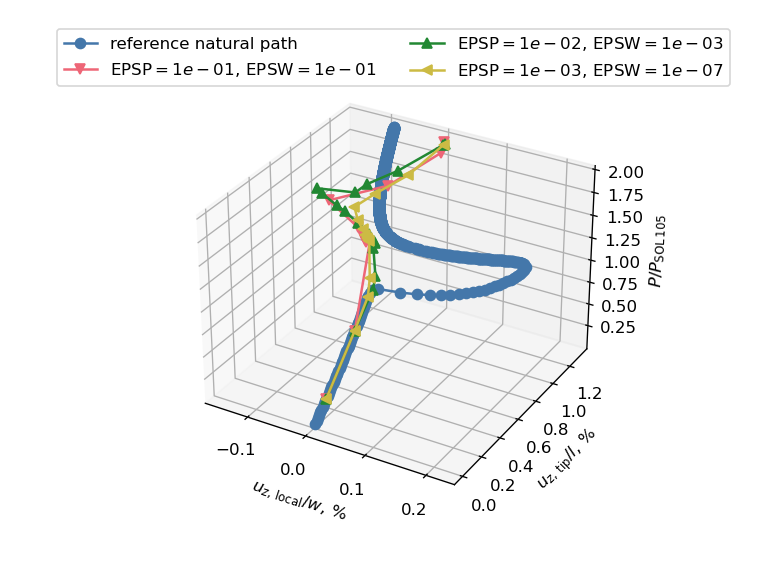

In [45]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_w = epsw
    input_name = f"sol_106_epsp{epsp:.0e}_epsw{epsw:.0e}"
    plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1],
                                   f"$\mathrm{{EPSP}}={epsp:.0e},\,\mathrm{{EPSW}}={epsw:.0e}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=2)
plt.show()

The equilibrium diagram shows that, altough the new load-displacement curves are not perfectly overlapping, there isn't a significative difference between them. In addition, they all appear to converge to the same final equilibrium point, which is characterized by the deformation that we showed earlier. This means that in all three analyses, the arc-length solver jumped at a certain point from the natural to the complementary path, even for the case with the tightest convergence tolerances, $\mathrm{EPSP}=10^{-3},\,\mathrm{EPSW}=10^{-7}$. In such case, the jump appears to occur at the fourth arc-length increment. We then inspect the f06 file at such increment to check the value of the error functions.

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         3  2.4017E-04  3.6442E-07  4.8129E-11  1.0000E-01  8.4326E-06  1.0000E+00  4.9709E-04  4.9709E-04    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    1     LOOPID    4     LOAD STEP    0.529     LOAD FACTOR 0.52855268
```

The load and energy error functions achieve a value of $3.6\cdot 10^{-7}$ and $4.8\cdot 10^{-11}$, respectively, at the third iteration. At this point, we want to test whether we are able to keep the arc-length solver on the natural equilibrium path by tightening the convergence tolerances, such that the solver is forced to bisect the increment.

We set the load and energy error functions to $3\cdot 10^{-7}$ and $7\cdot 10^{-11}$, respectively, and we run the analysis. We also increase the maximum number of bisections to $10$ in order to allow the solver to bisect the increment more times.


Nastran job sol_106_epsp3e-07_epsw4e-11.bdf completed
Wall time: 653.0 s


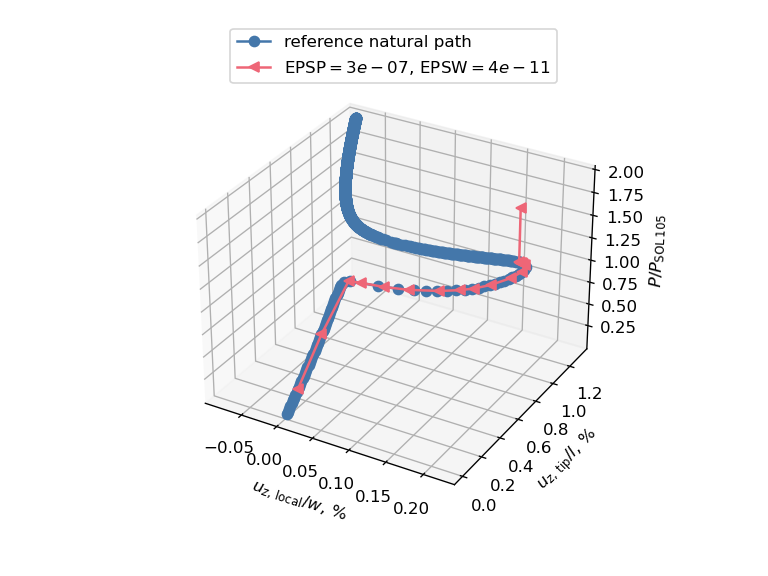

In [46]:
# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Modify load and work tolerances and run analysis
epsp, epsw = 3e-7, 4e-11
box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = epsp
box_beam_bdf.nlparms[coarse_nlparm_id].eps_w = epsw
box_beam_bdf.nlparms[coarse_nlparm_id].max_bisect = 10  # increase maximum number of bisections per increment
input_name = f"sol_106_epsp{epsp:.0e}_epsw{epsw:.0e}"
plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1],
                               f"$\mathrm{{EPSP}}={epsp:.0e},\,\mathrm{{EPSW}}={epsw:.0e}$", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center')
plt.show()

The equilibrium diagram shows that the arc-length solver is now able to follow the natural equilibrium path without jumping to a complementary path. However, the analysis stops approximately at the first load limit point due to a regression to an earlier load step. We could try to change the initial arc-length increment or other nonlinear analysis parameters to avoid this issue, but this is beyond the scope of what we wanted to demonstrate.

We restore the default values for the convergence tolerances of the load and energy function, and we move on to the next nonlinear analysis parameter.

In [47]:
box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = 1e-2
box_beam_bdf.nlparms[coarse_nlparm_id].eps_w = 1e-3


### Initial load increment <a name="initial-load-increment"></a>

Now we consider three different values of initial load increment:
- $\Delta\mu^1=0.5$;
- $\Delta\mu^1=0.1$ (default);
- $\Delta\mu^1=0.01$.

Nastran job sol_106_delta_mu1_5e-01.bdf completed
Wall time: 196.0 s
Nastran job sol_106_delta_mu1_1e-01.bdf completed
Wall time: 291.0 s
Nastran job sol_106_delta_mu1_1e-02.bdf completed
Wall time: 1333.0 s


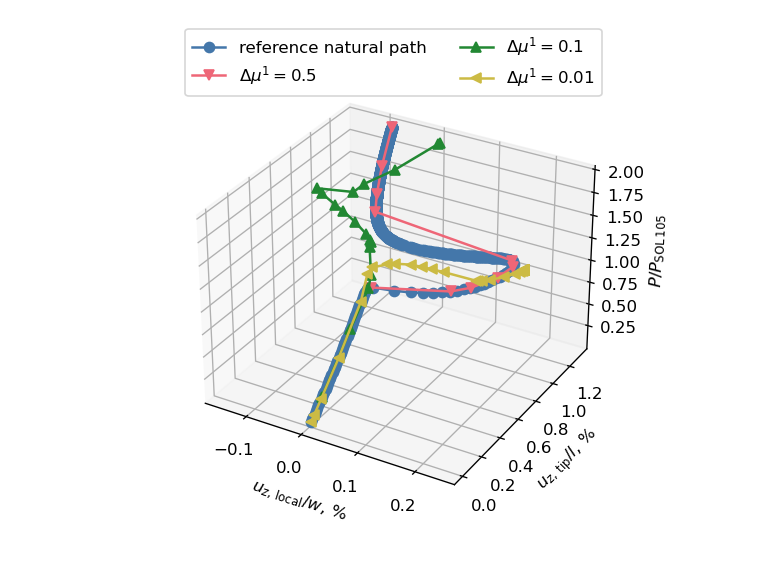

In [48]:
initial_load_increments = [.5, .1, .01]  # define list of initial load increments
box_beam_bdf.nlpcis[coarse_nlparm_id].mxinc = 100  # increase maximum number of increments to 100 to avoid the analysis with small initial load increment to stop prematurely

# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, delta_mu1 in enumerate(initial_load_increments):
    box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/delta_mu1)
    input_name = f"sol_106_delta_mu1_{delta_mu1:.0e}"
    plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1], f"$\Delta\mu^1={delta_mu1:.9g}$", run_flag=False)
    
# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=2)
plt.show()

In thi case we obtain three different load-displacement curves! Two of the analyses jump to two different complementary paths, while one follows the natural equilibrium path. Funnily enough, the analysis employing the largest initial load increment is the one where all equilibrium points lie on the natural equilibrium path, while the other two analyses, with smaller initial load increment, jump to a complementary path. This should not be of too much surprise: in fact, by considering one parameter at a time, it is difficult to robustly trace the natural equilibrium path, given the chaotic nature of the basin of attractions of the solutions of a nonlinear system.

The analysis with $\Delta\mu^1=0.01$ stops because it reaches the maximum number of bisections.

We restore the default value of the initial load increment and we move on to the next nonlinear analysis parameter.

In [49]:
box_beam_bdf.nlparms[coarse_nlparm_id].ninc = round(1/.1)

### Desired number of iterations <a name="desiter"></a>

Now we investigate the influence of the desired number of iterations, using the following values:
- $I_d=20$;
- $I_d=12$ (default);
- $I_d=5$.

Nastran job sol_106_desiter20.bdf completed
Wall time: 721.0 s
Nastran job sol_106_desiter12.bdf completed
Wall time: 381.0 s
Nastran job sol_106_desiter5.bdf completed
Wall time: 175.0 s


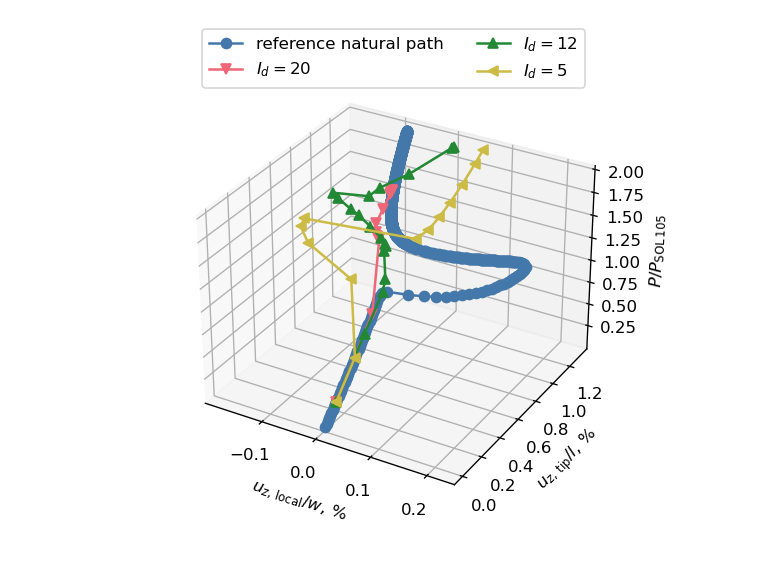

In [50]:
no_desired_iterations = [20, 12, 5]  # define list of desired numbers of iterations

# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, desiter in enumerate(no_desired_iterations):
    box_beam_bdf.nlpcis[coarse_nlparm_id].desiter = desiter
    input_name = f"sol_106_desiter{desiter:d}"
    plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1], f"$I_d={desiter:d}$", run_flag=False)
    
# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=2)
plt.show()

Also in this case we obtain three different equilibrium curves. The analysis with $I_d=20$ stops because it reaches the maximum number of bisections. Instead, the analysis with $I_d=5$ converges to the prescribed applied load of $P/P_\text{SOL 105}=2$ and suggests the existence of another complementary equilibrium path.

We try to explore this new complementary path by unloading the structure from the last equilibrium point of the analysis with $I_d=5$.

Nastran job sol_106_desiter5_equilibrium_path_verification.bdf completed
Wall time: 3180.0 s


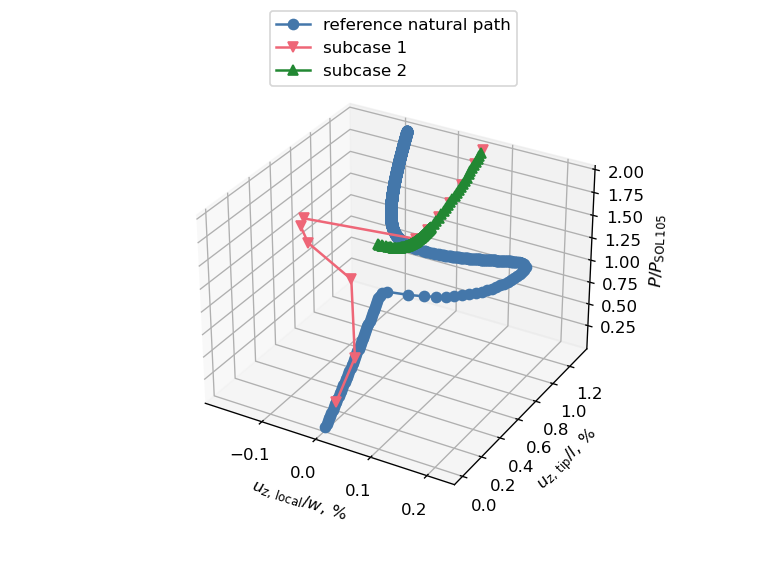

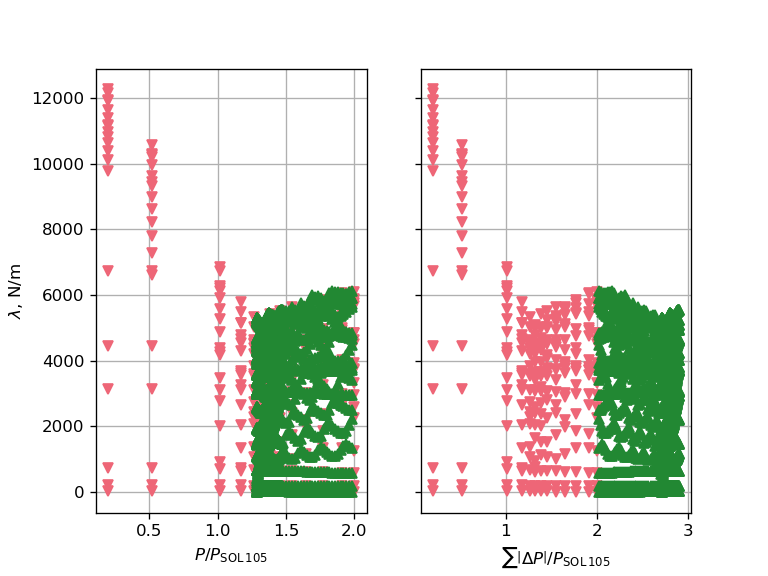

In [51]:
# Define second subcase to unload the structure
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=SECOND_SUBCASE_ID, load_set_id=zero_load_set_id)  # create subcase with zero applied load
box_beam_bdf.case_control_deck.subcases[SECOND_SUBCASE_ID].add_integer_type('NLPARM', fine_nlparm_id)  # use NLPARM and NLPCI with fine arc-length step in second subcase

# Run analysis
input_name = "sol_106_desiter5_equilibrium_path_verification"
sol_106_op2 = pynastran_utils.run_sol_106_with_kllrh_eigenvalues(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, upper_eig=UPPER_EIGENVALUE, run_flag=False)

# Read load and displacement history from op2 file
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=tip_master_node_id[ORIGINAL_MESH_KEY])
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id[ORIGINAL_MESH_KEY])

# Plot equilibrium paths and eigenvalues
plot_subcases_equilibrium_path(applied_loads, local_displacements, tip_displacements)
plot_subcases_eigenvalues(input_name, applied_loads)

The second subcase unloads the structure down to approximately $P/P_\text{SOL 105}=1.29$ and then the solver starts loading the structure again along the same load-displacement trajectory. Similarly to the previous complementary path, the eigenvalue diagram shows the presence of a negative eigenvalue where the solver "bounces back" on the load-displacement curve, suggesting the presence of a limit point. Inspecting the equilibrium diagram, we observe the probable presence of a load limit point, and we infer that the arc-length solver does not succeed in following the complementary equilibrium path beyond the load limit point, and it bounces back along the loading trajectory.

Before moving on to the next nonlinear analysis parameter, we plot the deformation of the box beam at the last equilibrium point of the first subcase and we compare it to the deformation on the natural equilibrium path.

Deformation on reference natural path:


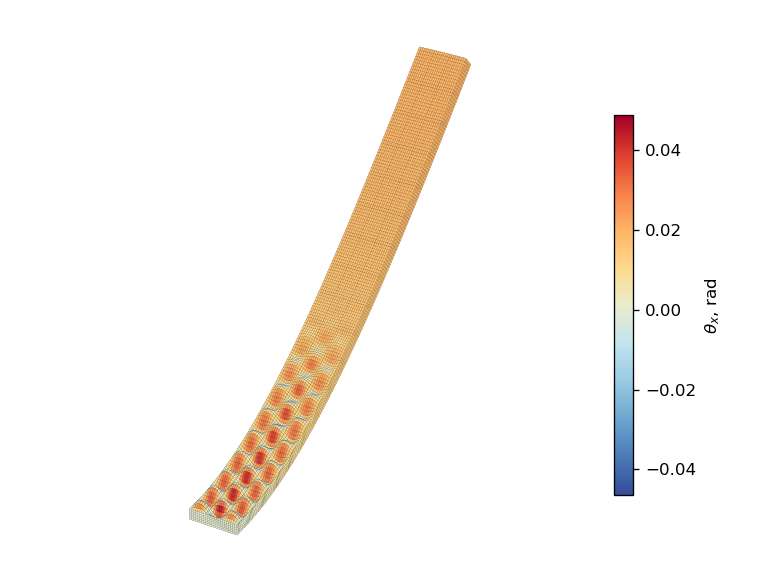

Deformation on complementary path:


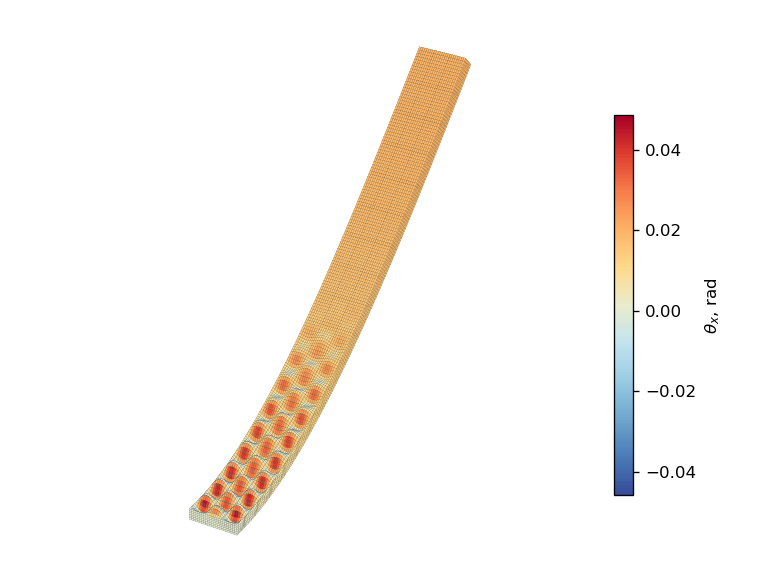

In [52]:
# Plot deformation on reference natural path
print("Deformation on reference natural path:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[ORIGINAL_MESH_KEY], subcase_id=FIRST_SUBCASE_ID,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

# Plot deformation at the end of first subcase of the new analysis
print("Deformation on complementary path:")
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2, subcase_id=FIRST_SUBCASE_ID,
                                                      displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.axis('off')
plt.show()

The deformation on the complementary path is characterized by the same number of half-waves in all rib-stiffeners bays as that on the natural path, but with the opposite phase.

We restore the default value of the desired number of iterations, delete the second subcase, and we move on to the next nonlinear analysis parameter.

In [53]:
box_beam_bdf.nlpcis[coarse_nlparm_id].desiter = 12
del box_beam_bdf.subcases[SECOND_SUBCASE_ID]

### Minimum allowable arc-length adjustment ratio <a name="minalr"></a>

Next, we assess the effect of the minimum allowable arc-length adjustment ratio, investigating three values:
- $\mathrm{MINALR}=0.9$;
- $\mathrm{MINALR}=0.25$ (default);
- $\mathrm{MINALR}=0.01$.

Nastran job sol_106_minalr0p9.bdf completed
Wall time: 377.0 s
Nastran job sol_106_minalr0p25.bdf completed
Wall time: 380.0 s
Nastran job sol_106_minalr0p01.bdf completed
Wall time: 369.0 s


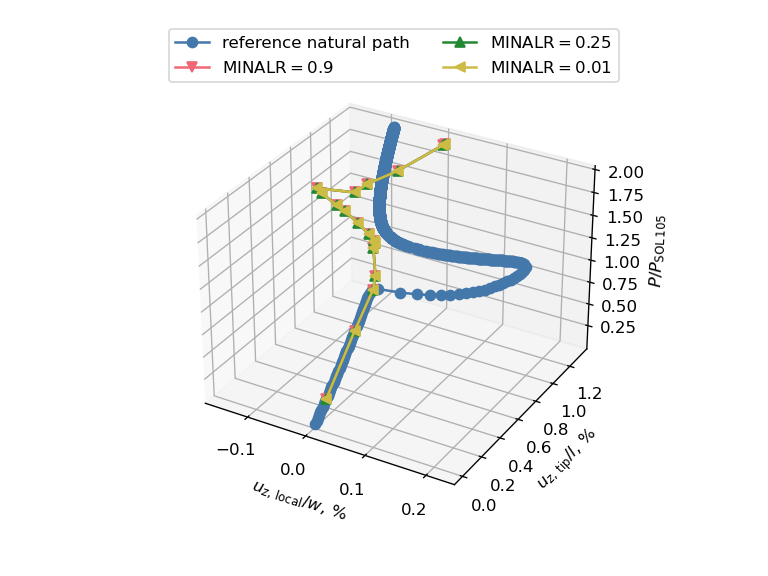

In [54]:
min_arclength_adjustment_ratios = [.9, .25, .01]  # define list of minimum allowable arc-length adjustment ratios

# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].minalr = minalr
    input_name = f"sol_106_minalr{minalr:.9g}".replace(".", "p")
    plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1], f"$\mathrm{{MINALR}}={minalr:.9g}$", run_flag=False)
    
# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=2)
plt.show()

In this case we obtain three overlapping load-displacement curves, suggesting that in this situation the minimum allowable arc-length adjustment ratio does not influence the results of the analysis.

We restore the default value and we move on to the last nonlinear analysis parameter.

In [55]:
box_beam_bdf.nlpcis[coarse_nlparm_id].minalr = .25

### Maximum allowable arc-length adjustment ratio <a name="maxalr"></a>

Finally, we consider three different maximum allowable arc-length adjustment ratios:
- $\mathrm{MAXALR}=10$;
- $\mathrm{MAXALR}=4$ (default);
- $\mathrm{MAXALR}=1.01$;
- $\mathrm{MAXALR}=1.0001$.

Nastran job sol_106_maxalr8.bdf completed
Wall time: 364.0 s
Nastran job sol_106_maxalr4.bdf completed
Wall time: 358.0 s
Nastran job sol_106_maxalr1p01.bdf completed
Wall time: 220.0 s
Nastran job sol_106_maxalr1p0001.bdf completed
Wall time: 1703.0 s


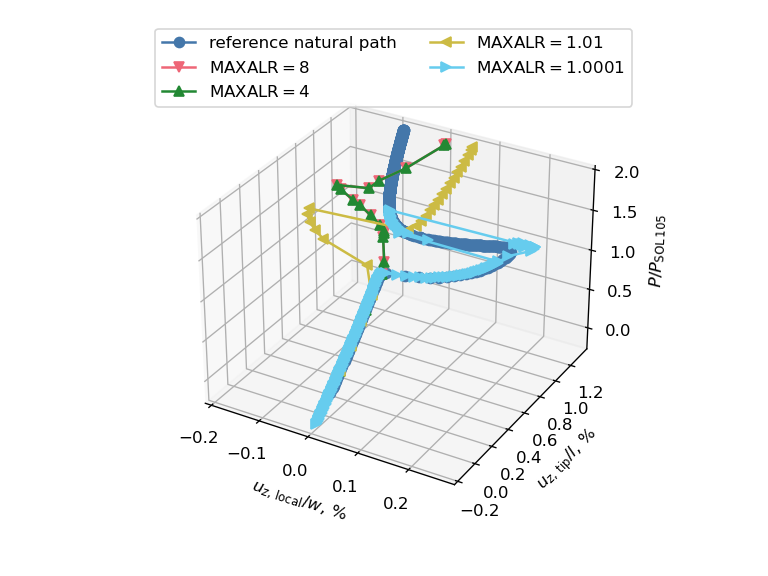

In [56]:
max_arclength_adjustment_ratios = [8., 4., 1.01, 1.0001]  # define list of minimum allowable arc-length adjustment ratios

# Plot natural equilibrium path
ax = plot_reference_equilibrium_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf.nlpcis[coarse_nlparm_id].maxalr = maxalr
    input_name = f"sol_106_maxalr{maxalr:.9g}".replace(".", "p")
    plot_analysis_equilibrium_path(box_beam_bdf, input_name, ax, markers[count + 1], f"$\mathrm{{MAXALR}}={maxalr:.9g}$", run_flag=False)
    
# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.11), loc='upper center', ncol=2)
plt.show()

The load-displacement curves obtained for $MAXALR=8$, $4$ and $1.01$ describe the presence of the complementary paths that we have already observed in the previous analyses. The analysis with $MAXALR=1.0001$ initially follows the natural path, jumping at a certain point on a complementary path, then back to the natural path and starts unloading the structure instead of keeping loading it. There is another jump between two points of the natural path and at a certain point the analysis stops because it reaches the maximum number of increments. This final result once again confirms that it is challenging to find a way to robustly trace the natural equilibrium path by varying only one nonlinear analysis parameter at a time.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have derived a new box beam model that approximates the geometry of the CRM wingbox, that we have called _CRM-like box beam_. Similarly to our previous notebooks we have considered the case of a concentrated tip load and we have performed a mesh convergence study to establish an appropriate mesh size for our analyses. This study resulted in a target element length equal to 169.6 mm, corresponidng to a model with 14976 elements, 85866 degrees of freedom and with a linear buckling load of 12517 N.

Successively, we have verified the convergence of the mesh in the nonlinear regime by comparing the equilibrium diagram of the original mesh with that of a refined mesh obtained by halving the target element length. The results showed the presence of a load limit point for both models, with a difference in the critical load of less than 5%.

We have also assessed the influence of SOL 106's nonlinear analysis parameters on the results of the analysis, and by doing so we showed the presence of some complementary paths. We have observed that it is challenging to find a way to robustly trace the natural equilibrium path by varying only one nonlinear analysis parameter at a time, due to the chaotic nature of the basin of attraction of the solutions of a nonlinear system.

When exploring the complementary paths, we have found that the arc-length solver bounced back at both displacement and load limit points, which is a known issue of arc-length control method. In another instance, have observed that the arc-length solver can follow the natural equilibrium path without jumping to a complementary path by tightening beyond a certain threshold the convergence tolerances, such that the solver is forced to bisect the increment. 

By comparing the deformation of the CRM-like box beam on the different equilibrium paths, we have found that the deformation on the complementary paths can be characterized by a different number of half-waves in some rib-stiffeners bays and by a phase shift with respect to that on the natural path.

In conclusion, we have gained a good understanding of the nonlinear behavior of the CRM-like box beam and in our [next notebook](19_One-variable_Optimization_of_the_CRM-like_Box_Beam.ipynb) we are going to attempt an optimization with nonlinear structural stability constraints.